In [ ]:
#| default_exp core

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle
from datetime import date 
from datetime import datetime
import datetime
from collections import defaultdict 
import nltk
nltk.download('words', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words
import glob

import re
import string
import pkg_resources

### utils 

In [ ]:
#| export
def file_loader(data_source):
    """
    Description:\n
        This is a helper function that 1. if data_source is a single file path in pickle/csv format, it reads it into a pd dataframe. 2. if it is a folder path, it reads csv and pickle files that match the pattern parameter in the data_source folder into one dataframe. \n
    
    Input:\n
        - data_source(str, pandas df): input path, csv or pickle file or a pattern to be matched when searching csv/pickle files that will be read into one dataframe.\n
    Output:\n
        - a pandas dataframe.\n
    """
    
    if isinstance(data_source, str):
        data_lst = glob.glob(data_source)
        dfs = []
        for x in data_lst:
            if x[-4:] == '.csv':
                dfs.append(pd.read_csv(x))
            elif x[-7:] == '.pickle':
                pickle_file = open(x, 'rb')
                pickle_file = pd.read_pickle(pickle_file)
                if not isinstance(pickle_file, pd.DataFrame):
                    return pickle_file
                dfs.append(pickle_file)
        df = pd.concat(dfs).reset_index(drop=True)
    else:
        df = data_source

        
    return df

This reads a specific csv file into a pd dataframe.

In [ ]:
file_loader("data/col_test_data/toy_data_2000.csv").head(2)

,original_logtime,desc_text,food_type,PID
0,2021-05-12 02:30:00 +0000,milk,b,yrt1999
1,2021-05-12 02:45:00 +0000,some medication,m,yrt1999


This reads in all files that matches yrt\*_food_data\*.csv pattern in data/col_test_data folder

In [ ]:
file_loader('data/col_test_data/yrt*_food_data*.csv').head(2)

,original_logtime,desc_text,food_type,PID
0,2021-05-12 02:30:00 +0000,Milk,b,yrt1999
1,2021-05-12 02:45:00 +0000,Some Medication,m,yrt1999


This reads all pickle and csv files in ./data/output folder.

In [ ]:
file_loader('data/output/*').head(2)

,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,original_logtime_notz,date,local_time,time,week_from_start,year,cleaned,day_count
0,7572733.0,alqt14018795225,150.0,Water,w,2017-12-08 17:30:00+00:00,2017-12-08 17:30:00+00:00,2017-12-08,17.500000,17:30:00,1.0,2017.0,NaN,NaN
1,411111.0,alqt14018795225,150.0,Coffee White,b,2017-12-09 00:01:00+00:00,2017-12-09 00:01:00+00:00,2017-12-08,24.016667,00:01:00,1.0,2017.0,NaN,NaN


In [ ]:
#| export
def find_date(data_source, col, h = 4):
    """
    Description:\n
        Extract date information from a column and shift each date in the column by h hours. (Day starts h hours early if h is negative and h hours late if h is positive)\n
        
    Input:\n
        - data_source(str, pandas df): input path, file in pickle, csv or pandas dataframe format\n
        - col(str) : column that contains the information of date and time, which is 24 hours system.
        - h(int) : hours to shift the date. For example, when h = 4, everyday starts and ends 4 hours later than normal.
        
    Return:\n
        - a pandas series represents the date extracted from col.\n

    Requirements:\n
        Elements in col should be pd.datetime objects
            
    """
    df = file_loader(data_source)
    
    if df[col].dtype == 'O':
        raise TypeError("'{}' column must be converted to datetime object".format(col))
        
    def find_date(d, h):
        if h > 0:
            if d.hour < h:
                return d.date() - pd.Timedelta('1 day')
        if h < 0:
            if d.hour+1 > (24+h):
                return d.date() + pd.Timedelta('1 day')
        return d.date()
    return df[col].apply(find_date, args=([h]))

In [ ]:
df = file_loader('data/test_food_details.csv')
df['original_logtime'] = pd.to_datetime(df['original_logtime'])
df['date'] = find_date(df, 'original_logtime')
df[['original_logtime', 'date']].head(3)

,original_logtime,date
0,2017-12-08 17:30:00+00:00,2017-12-08
1,2017-12-09 00:01:00+00:00,2017-12-08
2,2017-12-09 00:58:00+00:00,2017-12-08


In [ ]:
df['date'] = find_date(df, 'original_logtime', 4)
df[['original_logtime', 'date']].head(3)
# last two rows shift one day earlier due to that a day starts at 4 

,original_logtime,date
0,2017-12-08 17:30:00+00:00,2017-12-08
1,2017-12-09 00:01:00+00:00,2017-12-08
2,2017-12-09 00:58:00+00:00,2017-12-08


In [ ]:
df['date'] = find_date(df, 'original_logtime', -4)
df[['original_logtime', 'date']].head(5)

,original_logtime,date
0,2017-12-08 17:30:00+00:00,2017-12-08
1,2017-12-09 00:01:00+00:00,2017-12-09
2,2017-12-09 00:58:00+00:00,2017-12-09
3,2018-02-22 21:52:00+00:00,2018-02-23
4,2018-02-22 22:53:00+00:00,2018-02-23


note that last two rows shift one day later due to that a day ends at 20

In [ ]:
#| export
def find_float_time(data_source, col, h = 4):
    """
    Description:\n
        Extract time information from a column and shift each time by h hours. (Day starts h hours early if h is negative and h hours late if h is positive)\n
        
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or pandas dataframe format\n
        - col(str) : column that contains the information of date and time that's 24 hours system.
        - h(int) : hours to shift the date. For example, when h = 4, everyday starts at 4 and ends at 28. When h = -4, everyday starts at -4 and ends at 20.
        
    Return:\n
        - a pandas series with an index matching data_source; floating point time (clock hours) running from h to h per day.\n

    Requirements:\n
        Elements in col should be pd.datetime objects
        
    jf-updated-2023-04-17
            
    """
    df = file_loader(data_source)
    if df[col].dtype == 'O':
        raise TypeError("'{}' column must be converted to datetime object firsly".format(col))
    local_time = df[col].apply(lambda x: pd.Timedelta(x.time().isoformat()).total_seconds() /3600.)
    if h > 0:
        local_time = np.where(local_time < h, 24+ local_time, local_time)
        return pd.Series(local_time, index=df.index) #jf added index= to prevent mistaken assignments when data source and target df have a non-trivial index
    if h < 0:
        local_time = np.where(local_time > (24+h), local_time-24., local_time)
        return pd.Series(local_time, index=df.index)
    return local_time
    

In [ ]:
df = file_loader('data/test_food_details.csv')
df['original_logtime'] = pd.to_datetime(df['original_logtime'])

In [ ]:
df['float_time'] = find_float_time(df, 'original_logtime')
df[['original_logtime', 'float_time']].head(3)

,original_logtime,float_time
0,2017-12-08 17:30:00+00:00,17.500000
1,2017-12-09 00:01:00+00:00,24.016667
2,2017-12-09 00:58:00+00:00,24.966667


In [ ]:
df['float_time'] = find_float_time(df, 'original_logtime', 4)
df['date'] = find_date(df, 'original_logtime', 4)
df[['original_logtime','date', 'float_time']].head(3)
# last two rows shift one day earlier due to that a day starts at 4 and ends at 28

,original_logtime,date,float_time
0,2017-12-08 17:30:00+00:00,2017-12-08,17.500000
1,2017-12-09 00:01:00+00:00,2017-12-08,24.016667
2,2017-12-09 00:58:00+00:00,2017-12-08,24.966667


In [ ]:
df['float_time'] = find_float_time(df, 'original_logtime', -4)
df['date'] = find_date(df, 'original_logtime', -4)
df[['original_logtime','date', 'float_time']].head(5)
# last two rows shift one day later and local_time starts at -4 and ends at 20

,original_logtime,date,float_time
0,2017-12-08 17:30:00+00:00,2017-12-08,17.500000
1,2017-12-09 00:01:00+00:00,2017-12-09,0.016667
2,2017-12-09 00:58:00+00:00,2017-12-09,0.966667
3,2018-02-22 21:52:00+00:00,2018-02-23,-2.133333
4,2018-02-22 22:53:00+00:00,2018-02-23,-1.116667


In [ ]:
# versions < 1.0.5 did not explicitly set index for return of find_float_time()
# lets demonstrate that the indexing is lined up properly
test_times = pd.date_range("2021-03-01", periods=30, freq="H").to_series().rename('original_logtime').to_frame()
test_times['date'] = find_date(test_times, 'original_logtime', h=4)    
test_times['float_time'] = find_float_time(test_times, 'original_logtime', h=4)

test_times

,original_logtime,date,float_time
2021-03-01 00:00:00,2021-03-01 00:00:00,2021-02-28,24.0
2021-03-01 01:00:00,2021-03-01 01:00:00,2021-02-28,25.0
2021-03-01 02:00:00,2021-03-01 02:00:00,2021-02-28,26.0
2021-03-01 03:00:00,2021-03-01 03:00:00,2021-02-28,27.0
2021-03-01 04:00:00,2021-03-01 04:00:00,2021-03-01,4.0
2021-03-01 05:00:00,2021-03-01 05:00:00,2021-03-01,5.0
2021-03-01 06:00:00,2021-03-01 06:00:00,2021-03-01,6.0
2021-03-01 07:00:00,2021-03-01 07:00:00,2021-03-01,7.0
2021-03-01 08:00:00,2021-03-01 08:00:00,2021-03-01,8.0
2021-03-01 09:00:00,2021-03-01 09:00:00,2021-03-01,9.0


In [ ]:
#| export
def week_from_start(data_source, col, identifier):
        """
        Description:\n
            Calculate the number of weeks for each logging since the first day of the logging for each participant(identifier). The returned values for loggings from the first week are 1. 
        Input:\n
            - data_source (str, pandas df): input path, file in pickle, csv or pandas dataframe format\n
            - col (str): column name that contains date information from the data_source dataframe.
            - identifier (str): unique_id or ID, or name that identifies people.

        Return:\n
            - a numpy array represents the date extracted from col.\n
        """
        
        df = file_loader(data_source)
        if 'date' not in df.columns:
            raise NameError("There must exist a 'date' column.")
        # Handle week from start
        df_dic = dict(df.groupby(identifier)[col].agg(np.min))

        def count_weeks(s):
            return (s.date - df_dic[s[identifier]]).days // 7 + 1
    
        return df.apply(count_weeks, axis = 1)

In [ ]:
df = file_loader('data/test_food_details.csv')
df['original_logtime'] = pd.to_datetime(df['original_logtime'])

In [ ]:
# date column is a pre-requisite
df['date'] = find_date(df, 'original_logtime')
df['week_from_start'] = week_from_start(df, 'date', 'unique_code')
df[['unique_code','original_logtime','week_from_start']][2:4]

,unique_code,original_logtime,week_from_start
2,alqt14018795225,2017-12-09 00:58:00+00:00,1
3,alqt14018795225,2018-02-22 21:52:00+00:00,11


In [ ]:
#| export
def find_phase_duration(df):
    """
    Description:\n
        This is a function that calculates how many days each phase in the study took. Result includes the start and end date for that phase.
    
    Input:\n
        - df(pandas df) : information dataframe that contains columns: Start_Day, End_day
    
    Output:\n
        - a dataframe contains the phase_duration column.
        
    Requirement:\n
        - 'Start_day' and 'End_day' column exist in the df.
        - 'phase_duration' column exists in the df.
    """
    
    # checking if type conversion from string to datetime is necessary
    if df['Start_Day'].apply(lambda x: isinstance(x, str)).any():
        df['Start_Day'] = pd.to_datetime(df['Start_Day'])
    
    if df['End_day'].apply(lambda x: isinstance(x, str)).any():
        df['End_day'] = pd.to_datetime(df['End_day'])
    
    df['phase_duration'] = df['End_day'] - df['Start_Day']+ pd.Timedelta("1 days")
    return df

In [ ]:
find_phase_duration(pd.read_excel('data/col_test_data/toy_data_17May2021.xlsx'))[['phase_duration']]

,phase_duration
0,3 days
1,4 days
2,3 days
3,4 days
4,NaT


In [ ]:
#| export
def load_food_data(data_source, identifier, datetime_col, h):
    """
    Description:\n
        Load food data and output processed data in a dataframe.\n
    
        Process includes:\n
        1. Dropping 'foodimage_file_name' column.\n
        2. Handling the format of time by deleting am/pm by generating a new column, 'original_logtime_notz'\n
        3. Generating the date column with possible hour shifts, 'date'\n
        4. Converting time into float number into a new column with possible hour shifts, 'float_time'\n
        5. Converting time to a format of HH:MM:SS, 'time'\n
        6. Generating the column 'week_from_start' that contains the week number that the participants input the food item.\n
        7. Generating 'year' column based on the input data.\n

    Input:\n
        - data_source (str or pandas df): input path, csv file\n
        - identifier(str): id-like column that's used to identify a subject.\n
        - datetime_col(str): column that contains date and time in string format.\n
        - h(int) : hours to shift the date. For example, when h = 4, everyday starts and ends 4 hours later than normal.
        
    Output:\n
        - the processed dataframe in pandas df format.\n

    Requirements:\n
        data_source file must have the following columns:\n
            - foodimage_file_name\n
            - original_logtime\n
            - date\n
            - unique_code\n
    """
    food_all = file_loader(data_source)
    
    try:
        food_all = food_all.drop(columns = ['foodimage_file_name'])
    except KeyError:
        pass
    
    def handle_time(s):
        """
        helper function to get rid of am/pm in the end of each time string
        """
        tmp_s = s.replace('p.m.', '').replace('a.m.', '')
        try:
            return pd.to_datetime(' '.join(tmp_s.split()[:2]) )
        except:
            try:
                if int(tmp_s.split()[1][:2]) > 12:
                    tmp_s = s.replace('p.m.', '').replace('a.m.', '').replace('PM', '').replace('pm', '')
                return pd.to_datetime(' '.join(tmp_s.split()[:2]) )
            except:
                return np.nan

    food_all[datetime_col] = food_all[datetime_col].apply(handle_time)
    
    food_all = food_all.dropna().reset_index(drop = True)
    

    food_all['date'] = find_date(food_all, datetime_col, h)
    
    
    # Handle the time - Time in floating point format
    
    food_all['float_time'] = find_float_time(food_all, datetime_col, h)
    
    # Handle the time - Time in Datetime object format
    food_all['time'] = pd.DatetimeIndex(food_all[datetime_col]).time
    
    # Handle week from start
    food_all['week_from_start'] = week_from_start(food_all,'date',identifier)
    
    food_all['year'] = food_all.date.apply(lambda d: d.year)
    
    return food_all

In [ ]:
load_food_data('data/test_food_details.csv','unique_code', 'original_logtime', h=4).head(2)

,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,date,float_time,time,week_from_start,year
0,7572733,alqt14018795225,150,Water,w,2017-12-08 17:30:00+00:00,2017-12-08,17.500000,17:30:00,1,2017
1,411111,alqt14018795225,150,Coffee White,b,2017-12-09 00:01:00+00:00,2017-12-08,24.016667,00:01:00,1,2017


In [ ]:
#| export
def in_good_logging_day(data_source, identifier, date_col, time_col, min_log_num = 2, min_seperation = 4):
    """
    Description:\n
        A logging's in a good logging day if the there are more than min_log_num loggings in one day w/ more than min_seperation hoursx apart from the earliest logging and the latest logging and False otherwise.\n
        
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or pandas dataframe format.\n
        - identifier (str): id-like column that's used to identify a subject.\n
        - time_col (str): column that contains time in float format.\n
        - min_log_num (count,int): filtration criteria on the minimum number of loggings each day.\n
        - min_seperation(hours,int): filtration criteria on the minimum separations between the earliest and latest loggings each day.\n
        
    Return:\n
        - A boolean numpy array indicating whether the corresponding row is in a good logging day. Details on the criteria is in the description.\n
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col

    """
    def adherent(s):
        if len(s.values) >= min_log_num and (max(s.values) - min(s.values)) >= min_seperation:
            return True
        else:
            return False
        
    df = file_loader(data_source)
    
    adherent_dict = dict(df.groupby([identifier, date_col])[time_col].agg(adherent))

    
    return df.apply(lambda x: adherent_dict[(x[identifier], x.date)], axis = 1)

In [ ]:
df = load_food_data('data/test_food_details.csv', 'unique_code','original_logtime', 4)
df['in_good_logging_day'] = in_good_logging_day(df, 'unique_code', 'date', 'float_time')
df.head(2)

,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,date,float_time,time,week_from_start,year,in_good_logging_day
0,7572733,alqt14018795225,150,Water,w,2017-12-08 17:30:00+00:00,2017-12-08,17.500000,17:30:00,1,2017,True
1,411111,alqt14018795225,150,Coffee White,b,2017-12-09 00:01:00+00:00,2017-12-08,24.016667,00:01:00,1,2017,True


In [ ]:
#| export
class FoodParser():
    """
    A class that reads in food loggings from the app. Used as helper function for the function clean_loggings().
    """

    def __init__(self):
        # self.__version__ = '0.1.9'
        self.wnl = WordNetLemmatizer()
        # self.spell = SpellChecker()
        return

    ################# Read in Annotations #################
    def process_parser_keys_df(self, parser_keys_df):
        parser_keys_df = parser_keys_df.query('food_type in ["f", "b", "m", "w", "modifier", "general", "stopword", "selfcare"]').reset_index(drop = True)

        # 1. all_gram_sets
        all_gram_set = []
        for i in range(1, 6):
            all_gram_set.append(set(parser_keys_df.query('gram_type == ' + str(i)).gram_key.values))

        # 2. food_type_dict
        food_type_dict = dict(zip(parser_keys_df.gram_key.values, parser_keys_df.food_type.values))

        # 3. food2tag
        def find_all_tags(s):
            tags = []
            for i in range(1, 8):
                if not isinstance(s['tag' + str(i)], str) and np.isnan(s['tag' + str(i)]):
                    continue
                tags.append(s['tag' + str(i)])
            return tags
        food2tags = dict(zip(parser_keys_df.gram_key.values, parser_keys_df.apply(find_all_tags, axis = 1)))
        return all_gram_set, food_type_dict, food2tags


    def initialization(self):
        # 1. read in manually annotated file and bind it to the object
        
        # pypi version
#         parser_keys_df = pd.read_csv(pkg_resources.resource_stream(__name__, "/data/parser_keys.csv"))
#         all_gram_set, food_type_dict, food2tags = self.process_parser_keys_df(parser_keys_df)
#         correction_dic = pickle.load(pkg_resources.resource_stream(__name__, "/data/correction_dic.pickle"))
        
#         # testing version
        parser_keys_df = pd.read_csv("data/parser_keys.csv")
        all_gram_set, food_type_dict, food2tags = self.process_parser_keys_df(parser_keys_df)
        correction_dic = file_loader("data/correction_dic.pickle")
        
        
        self.all_gram_set = all_gram_set
        self.food_type_dict = food_type_dict
        self.correction_dic = correction_dic
        self.tmp_correction = {}


        # 2. Load common stop words and bind it to the object
        stop_words = stopwords.words('english')
        # Updated by Katherine August 23rd 2020
        stop_words.remove('out') # since pre work out is a valid beverage name
        stop_words.remove('no')
        stop_words.remove('not')
        self.stop_words = stop_words
        return

    ########## Pre-Processing ##########
    # Function for removing numbers
    def handle_numbers(self, text):
        clean_text = text
        clean_text = re.sub('[0-9]+\.[0-9]+', '' , clean_text)
        clean_text = re.sub('[0-9]+', '' , clean_text)
        clean_text = re.sub('\s\s+', ' ', clean_text)
        return clean_text

    # Function for removing punctuation
    def drop_punc(self, text):
        clean_text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
        return clean_text

    # Remove normal stopwords
    def remove_stop(self, my_text):
        text_list = my_text.split()
        return ' '.join([word for word in text_list if word not in self.stop_words])


    def pre_processing(self, text):
        text = text.lower()
        return self.remove_stop(self.handle_numbers(self.drop_punc(text))).strip()

    ########## Handle Format ##########
    def handle_front_mixing(self, sent, front_mixed_tokens):
        cleaned_tokens = []
        for t in sent.split():
            if t in front_mixed_tokens:
                number = re.findall('\d+[xX]*', t)[0]
                for t_0 in t.replace(number, number + ' ').split():
                    cleaned_tokens.append(t_0)
            else:
                cleaned_tokens.append(t)
        return ' '.join(cleaned_tokens)

    def handle_x2(self, sent, times_x_tokens):
        for t in times_x_tokens:
            sent = sent.replace(t, ' ' + t.replace(' ', '').lower() + ' ')
        return ' '.join([s for s in sent.split() if s != '']).strip()

    def clean_format(self, sent):
        return_sent = sent

        # Problem 1: 'front mixing'
        front_mixed_tokens = re.findall('\d+[^\sxX]+', sent)
        if len(front_mixed_tokens) != 0:
            return_sent = self.handle_front_mixing(return_sent, front_mixed_tokens)

        # Problem 2: 'x2', 'X2', 'X 2', 'x 2'
        times_x_tokens = re.findall('[xX]\s*?\d', return_sent)
        if len(times_x_tokens) != 0:
            return_sent = self.handle_x2(return_sent, times_x_tokens)
        return return_sent

    ########## Handle Typo ##########
    def fix_spelling(self, entry, speller_check = False):
        result = []
        for token in entry.split():
            # Check known corrections
            if token in self.correction_dic.keys():
                token_alt = self.wnl.lemmatize(self.correction_dic[token])
            else:
                if speller_check and token in self.tmp_correction.keys():
                    token_alt = self.wnl.lemmatize(self.tmp_correction[token])
                elif speller_check and token not in self.food_type_dict.keys():
                    token_alt = self.wnl.lemmatize(token)
                    self.tmp_correction[token] = token_alt
                else:
                    token_alt = self.wnl.lemmatize(token)
            result.append(token_alt)
        return ' '.join(result)

    ########### Combine all cleaning ##########
    def handle_all_cleaning(self, entry):
        cleaned = self.pre_processing(entry)
        cleaned = self.clean_format(cleaned)
        cleaned = self.fix_spelling(cleaned)
        return cleaned

    ########## Handle Gram Matching ##########
    def parse_single_gram(self, gram_length, gram_set, gram_lst, sentence_tag):
        food_lst = []
        # print(gram_length, gram_lst, sentence_tag)
        for i in range(len(gram_lst)):
            if gram_length > 1:
                curr_word = ' '.join(gram_lst[i])
            else:
                curr_word = gram_lst[i]
            if curr_word in gram_set and sum([t != 'Unknown' for t in sentence_tag[i: i+gram_length]]) == 0:
                sentence_tag[i: i+gram_length] = str(gram_length)
                food_lst.append(curr_word)
        return food_lst

    def parse_single_entry(self, entry, return_sentence_tag = False):
        # Pre-processing and Cleaning
        cleaned = self.handle_all_cleaning(entry)

        # Create tokens and n-grams
        tokens = nltk.word_tokenize(cleaned)
        bigram = list(nltk.ngrams(tokens, 2)) if len(tokens) > 1 else None
        trigram = list(nltk.ngrams(tokens, 3)) if len(tokens) > 2 else None
        quadgram = list(nltk.ngrams(tokens, 4)) if len(tokens) > 3 else None
        pentagram = list(nltk.ngrams(tokens, 5)) if len(tokens) > 4 else None
        all_gram_lst = [tokens, bigram, trigram, quadgram, pentagram]

        # Create an array of tags
        sentence_tag = np.array(['Unknown'] * len(tokens))

        all_food = []
        food_counter = 0
        for gram_length in [5, 4, 3, 2, 1]:
            if len(tokens) < gram_length:
                continue
            tmp_food_lst = self.parse_single_gram(gram_length,
                                                self.all_gram_set[gram_length - 1],
                                                all_gram_lst[gram_length - 1],
                                                sentence_tag)
            all_food += tmp_food_lst
        if return_sentence_tag:
            return all_food, sentence_tag
        else:
            return all_food

    def parse_food(self, entry, return_sentence_tag = False):
        result = []
        unknown_tokens = []
        num_unknown = 0
        num_token = 0
        for w in entry.split(','):
            all_food, sentence_tag = self.parse_single_entry(w, return_sentence_tag)
            result += all_food
            if len(sentence_tag) > 0:
                num_unknown += sum(np.array(sentence_tag) == 'Unknown')
                num_token += len(sentence_tag)
                cleaned = nltk.word_tokenize(self.handle_all_cleaning(w))

                # Return un-catched tokens, groupped into sub-sections
                tmp_unknown = ''
                for i in range(len(sentence_tag)):
                    if sentence_tag[i] == 'Unknown':
                        # unknown_tokens.append(cleaned[i])
                        tmp_unknown += (' ' + cleaned[i])
                        if i == len(sentence_tag) - 1:
                            unknown_tokens.append(tmp_unknown)
                    elif tmp_unknown != '':
                        unknown_tokens.append(tmp_unknown)
                        tmp_unknown = ''

        if return_sentence_tag:
            return result, num_token, num_unknown, unknown_tokens
        else:
            return result

    def find_food_type(self, food):
        if food in self.food_type_dict.keys():
            return self.food_type_dict[food]
        else:
            return 'u'

    ################# DataFrame Functions #################
    def expand_entries(self, df):
        assert 'desc_text' in df.columns, '[ERROR!] Required a column of "desc_text"!!'

        all_entries = []
        for idx in range(df.shape[0]):
            curr_row = df.iloc[idx]
            logging = curr_row.desc_text
            tmp_dict = dict(curr_row)
            if ',' in logging:
                for entry in logging.split(','):
                    tmp_dict = tmp_dict.copy()
                    tmp_dict['desc_text'] = entry
                    all_entries.append(tmp_dict)
            else:
                tmp_dict['desc_text'] = logging
                all_entries.append(tmp_dict)

        return pd.DataFrame(all_entries)

In [ ]:
#| export 
def clean_loggings(data_source, text_col, identifier):
    """
    Description:\n
       This function convert all the loggings in the data_source file into a list of typo-corrected items based on the text_col column. This function is based on a built-in vocabulary dictionary and an n-gram searcher.\n
       
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - text_col(str): column that will be converted to individual items.
        - identifier(str): participants' unique identifier such as id, name, etc.
        
    Return:\n
        - A dataframe contains the cleaned version of the text_col.\n

    """

    food_all = file_loader(data_source)
    # initialize food parser instance
    fp = FoodParser()
    fp.initialization()
    
    # parse food
    parsed = [fp.parse_food(i, return_sentence_tag = True) for i in food_all.desc_text.values]
    
    food_all_parsed = pd.DataFrame({
    identifier: food_all[identifier],
    text_col: food_all[text_col],
    'cleaned': parsed
    })
    
    food_all_parsed['cleaned'] = food_all_parsed['cleaned'].apply(lambda x: x[0])
    
    
    return food_all_parsed

In [ ]:
clean_loggings('data/output/public.pickle', 'desc_text', 'unique_code').head(3)

,unique_code,desc_text,cleaned
0,alqt14018795225,Water,[water]
1,alqt14018795225,Coffee White,"[coffee, white]"
2,alqt14018795225,Salad,[salad]


In [ ]:
#| export
def get_types(data_source, food_type):
    """
    Description:\n
       This function filters with the expected food types and return a cleaner version of data_source file.\n 
       
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.\n
        - food_type (str): expected types of the loggings for filtering, in format of list. Available types:  \n
            1. 'w' : water \n
            2. 'b' : beverage \n
            3. 'f' : food \n
            4. 'm' : medicine \n
        
    Return:\n
        - A filtered dataframe with expected food type/types with five columns: 'unique_code','food_type', 'desc_text', 'date', 'local_time'.\n
        
    Requirements:\n
        data_source file must have the following columns:\n
            - food_type\n
            
    """
    
    df = file_loader(data_source)
        
    if len(food_type) == 0:
        return df
    
    if len(food_type) == 1:
        if food_type[0] not in ['w', 'b', 'f', 'm']:
            raise Exception("not a valid logging type")
        filtered = df[df['food_type']==food_type[0]]
    else:  
        filtered = df[df['food_type'].isin(food_type)]
        
    
    return filtered

In [ ]:
get_types('data/output/public_basline_usable_expanded.pickle',['w', 'f'])[['unique_code','desc_text','food_type']].head(3)

,unique_code,desc_text,food_type
0,alqt14018795225,Water,w
2,alqt14018795225,Salad,f
3,alqt78896444285,Water,w


In [ ]:
df = load_food_data('data/test_food_details.csv', 'unique_code', 'original_logtime', 4)
get_types(df, ['m'])[['unique_code','desc_text','food_type']].head(3)

,unique_code,desc_text,food_type
323,alqt14018795225,Caffeine,m
361,alqt14018795225,Caffeine,m
420,alqt14018795225,Caffeine,m


In [ ]:
#| export
def count_caloric_entries(df):
    """
    Description:\n
        This is a function that counts the number of food and beverage loggings.
    
    Input:\n
        - df(pandas df) : food_logging data.
    
    Output:\n
        - a float representing the number of caloric entries.
        
    Requirement:\n
        - 'date' column existed in the df.
    """
    if 'food_type' not in df.columns:
        raise Exception("'food_type' column must exist in the dataframe.")
        
    
    return df[df['food_type'].isin(['f','b'])].shape[0]

In [ ]:
df = load_food_data('data/test_food_details.csv', 'unique_code', 'original_logtime', 4)
count_caloric_entries(df)

4603

In [ ]:
#| export
def mean_daily_eating_duration(df, date_col, time_col):
    """
    Description:\n
        This is a function that calculates the mean daily eating window, which is defined as the duration of first and last caloric intake.
    
    Input:\n
        - df(pandas df) : food_logging data.
        - date_col(column existed in df, string) : column name that contains date information from the df dataframe.
        - time_col(column existed in df, string) : contains the float time data for each logging.
    
    Output:\n
        - a float representing the mean daily eating window.
        
    Requirement:\n
        - 'date' column existed in the df.
        - float time is calculated.
        
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """

    df = df[df['food_type'].isin(['f','b'])]
    breakfast_time = df.groupby(date_col)[time_col].agg(min)
    dinner_time = df.groupby(date_col)[time_col].agg(max)
    return (dinner_time - breakfast_time).mean()

In [ ]:
df = load_food_data('data/test_food_details.csv', 'unique_code', 'original_logtime', 4)
mean_daily_eating_duration(df, 'date', 'float_time')

14.038679245283017

In [ ]:
#| export
def std_daily_eating_duration(df, date_col, time_col):
    """
    Description:\n
        This function calculates the standard deviation of daily eating window, which is defined as the duration between the first and last caloric intake.
    
    Input:\n
        - df(pandas df) : food_logging data.
        - date_col(column existed in df, string) : column name that contains date information from the df dataframe.
        - time_col(column existed in df, string) : contains the float time data for each logging.
    
    Output:\n
        - a float representing the standard deviation of daily eating window.
        
    Requirement:\n
        - 'food_type' column existed in the df.
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    
    df = df[df['food_type'].isin(['f','b'])]
    breakfast_time = df.groupby(date_col)[time_col].agg(min)
    dinner_time = df.groupby(date_col)[time_col].agg(max)

    return (dinner_time - breakfast_time).std()

In [ ]:
df = load_food_data('data/test_food_details.csv', 'unique_code', 'original_logtime', 4)
std_daily_eating_duration(df, 'date', 'float_time' )

7.018679942775867

In [ ]:
#| export
def earliest_entry(df, date_col, time_col):
    """
    Description:\n
        This function calculates the earliest first calorie on any day in the study period. 
    Input:\n
        - df(pandas df) : food_logging data.
        - date_col(column existed in df, string) : column name that contains date information from the df dataframe.
        - time_col(column existed in df, string) : contains information of logging time in float.
    
    Output:\n
        - the earliest caloric time in float on any day in the study period. 
        
    Requirement:\n
        - 'date' column existed in the df.
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    
    df = get_types(df, ['f', 'b'])
    
    return df[time_col].min()

In [ ]:
df = load_food_data('data/test_food_details.csv','unique_code', 'original_logtime', 4)
earliest_entry(df, 'date', 'float_time')

4.0

In [ ]:
#| export
def mean_first_cal(df, date_col, time_col):
    """
    Description:\n
        This function calculates the average time of first calory intake. 
    Input:\n
        - df(pandas df) : food_logging data.
        - date_col(column existed in df, string) : column name that contains date information from the df dataframe.
        - time_col(column existed in df, string) : contains information of logging time in float.
    
    Output:\n
        - the mean first caloric intake time in float in the study period. 
        
    Requirement:\n
        - 'date' column existed in the df.
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    
    
    return df.groupby([date_col])[time_col].min().mean()

In [ ]:
df = load_food_data('data/test_food_details.csv','unique_code', 'original_logtime', 4)
mean_first_cal(df, 'date', 'float_time')

8.335744234800838

In [ ]:
# find the average mean first cal time for each participant
df.groupby('unique_code').agg(mean_first_cal, 'date', 'float_time').iloc[:,0]

unique_code
alqt1148284857      7.821795
alqt14018795225     7.525781
alqt16675467779     5.656757
alqt21525720972    11.241486
alqt45631586569    14.690558
alqt5833085442      9.170455
alqt62359040167     7.252137
alqt6695047873      7.763008
alqt78896444285     5.259770
alqt8668165687      8.256569
Name: ID, dtype: float64

In [ ]:
#| export
def std_first_cal(df, date_col, time_col):
    """
    Description:\n
        This function calculates the average time of first calory intake. 
    Input:\n
        - df(pandas df) : food_logging data.
        - date_col(column existed in df, string) : column name that contains date information from the df dataframe.
        - time_col(column existed in df, string) : contains information of logging time in float.
    
    Output:\n
        - the mean first caloric intake time in float in the study period. 
        
    Requirement:\n
        - 'date' column existed in the df.
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    
    
    return df.groupby([date_col])[time_col].min().std()

In [ ]:
df = load_food_data('data/test_food_details.csv','unique_code', 'original_logtime', 4)
std_first_cal(df, 'date', 'float_time')

4.488379313189289

In [ ]:
#| export
def mean_last_cal(df, date_col, time_col):
    """
    Description:\n
        This function calculates the average time of last calory intake. 
    Input:\n
        - df(pandas df) : food_logging data.
        - date_col(column existed in df, string) : column name that contains date information from the df dataframe.
        - time_col(column existed in df, string) : contains information of logging time in float.
    
    Output:\n
        - the mean last caloric intake time in float in the study period. 
        
    Requirement:\n
        - 'date' column existed in the df.
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    
    
    return df.groupby([date_col])[time_col].max().mean()

In [ ]:
df = load_food_data('data/test_food_details.csv','unique_code', 'original_logtime', 4)
mean_last_cal(df, 'date', 'float_time')

23.88763102725367

In [ ]:
#| export
def std_last_cal(df, date_col, time_col):
    """
    Description:\n
        This function calculates the average time of last calory intake. 
    Input:\n
        - df(pandas df) : food_logging data.
        - date_col(column existed in df, string) : column name that contains date information from the df dataframe.
        - time_col(column existed in df, string) : contains information of logging time in float.
    
    Output:\n
        - the mean last caloric intake time in float in the study period. 
        
    Requirement:\n
        - 'date' column existed in the df.
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    
    
    return df.groupby([date_col])[time_col].max().std()

In [ ]:
df = load_food_data('data/test_food_details.csv','unique_code', 'original_logtime', 4)
std_last_cal(df, 'date', 'float_time')

4.081319697979822

In [ ]:
#| export
def logging_day_counts(df):
    """
    Description:\n
        This function calculates the number of days that contains any loggings. 
    Input:\n
        - df(pandas df) : food_logging data.
    
    Output:\n
        - an integer that represents the number of logging days.
        
    Requirement:\n
        - 'date' column existed in the df.
    """
    
    return df.date.nunique()

In [ ]:
df = load_food_data('data/test_food_details.csv', 'unique_code', 'original_logtime', 4)
logging_day_counts(df)

636

In [ ]:
#| export
def find_missing_logging_days(df, start_date='not_defined', end_date='not_defined'):
    """
    Description:\n
        This function finds the days during which there's no logging within the period from start_date to end_date. 
    Input:\n
        - df(panda df): food_logging data.
        - start_date(datetime.date object): start date of the period of calculation. If not defined, it will be automatically set to be the earliest date in df. 
        - end_date(datetime.date object): end date of the period of calculation. If not defined, it will be automatically set to be the latest date in df.
    
    Output:\n
        - a list that contains all of the dates that don't contain loggings.
        
    Requirement:\n
        - 'date' column existed in the df.
    """
    # if start_date or end_date is missing, return nan
    if pd.isnull(start_date) or pd.isnull(end_date):
        return np.nan
    # if there is no input on start_date or end_date, use earliest date and latest date
    if start_date=='not_defined':
        start_date = df['date'].min()
    if end_date=='not_defined':
        end_date = df['date'].max()
        
    df = df[(df['date']>=start_date) & (df['date']<=end_date)]
    
    # get all the dates between two dates
    lst = []
    for x in pd.date_range(start_date, end_date, freq='d'):
         if x not in df['date'].unique():
                lst.append(x.date())
    
    return lst
        

In [ ]:
df = load_food_data('data/test_food_details.csv', 'unique_code', 'original_logtime', 4)
find_missing_logging_days(df, datetime.date(2017, 12, 7), datetime.date(2017, 12, 10))

[datetime.date(2017, 12, 7),
 datetime.date(2017, 12, 8),
 datetime.date(2017, 12, 9),
 datetime.date(2017, 12, 10)]

In [ ]:
#| export
def good_lwa_day_counts(df, window_start, window_end, time_col, min_log_num=2, min_seperation=5, buffer_time= '15 minutes',h=4, start_date='not_defined', end_date='not_defined'):
    """
    Description:\n
        This function calculates the number of good logging days, good window days, outside window days and adherent days. Good logging day is defined as a day that the person makes at least min_log_num number of loggings and the time separation between the earliest and the latest logging are greater than min_seperation.\n
        A good window day is defined as a date that all the food loggings are within the assigned restricted window. An adherent day is defined as a date that is both a good logging day and a good window day.
    Input:\n
        - df(pandas df): food_logging data.
        - window_start(datetime.time object): start time of the restriction window.
        - window_end(datetime.time object): end time of the restriction window.
        - time_col(str) : the column that represents the eating time.
        - min_log_num(count, int): minimum number of loggings to qualify a day as a good logging day
        - min_seperation(hours, int): minimum period of separation between earliest and latest loggings to qualify a day as a good logging day
        - buffer_time(time in string that can be passed into pd.Timedelta()): wiggle room for to be added/subtracted on the ends of windows.
        - h(hours, int): hours to be pushed back
        - start_date(datetime.date object): start date of the period for calculation. If not defined, it will be automatically set to be the earliest date in df.
        - end_date(datetime.date object): end date of the period for calculation. If not defined, it will be automatically set to be the latest date in df.
    Output:\n
        - Two lists.
            - First list contains 4 integers that represent the number of good logging days, good window days, outside window days and adherent_days
            - Second list contains lists consisted of specific dates that are not good logging days, window days and adherent days within the range of start date and end date(both inclusive).
    Requirement:\n
        - 'date' column existed in the df.
        - float time is calculated as time_col.

    """
    # if start_date or end_date is missing, return nan
    if pd.isnull(start_date) or pd.isnull(end_date):
        return [np.nan,np.nan,np.nan,np.nan], [[],[],[]]
    
    # if window start or window end are nan, make the windows the same as control's window time.
    if pd.isnull(window_start):
        window_start = datetime.time(0,0)
    if pd.isnull(window_end):
        window_end = datetime.time(23,59)
        
    # if there is no input on start_date or end_date, use earliest date and latest date
    if start_date=='not_defined':
        start_date = df['date'].min()
    if end_date=='not_defined':
        end_date = df['date'].max()

    # helper function to determine a good logging
    def good_logging(local_time_series):
        if len(local_time_series.values) >= min_log_num and (max(local_time_series.values) - min(local_time_series.values)) >= min_seperation:
            return True
        else:
            return False

    df = df[(df['date']>=start_date) & (df['date']<=end_date)]
    df = df[df['food_type'].isin(['f','b'])]
    df['original_logtime'] = pd.to_datetime(df['original_logtime']).dt.tz_localize(None)

    buffer_time = pd.Timedelta(buffer_time).total_seconds()/3600.

    in_window_count = []
    daily_count = []
    good_logging_count = []
    cur_dates = df['date'].sort_values(ascending = True).unique()
    for aday in cur_dates:
        window_start_daily = window_start.hour+window_start.minute/60- buffer_time
        window_end_daily = window_end.hour+window_end.minute/60 + buffer_time
        tmp = df[df['date']==aday]
        if (window_start == datetime.time(0,0)) and (window_end == datetime.time(23,59)):
            in_window_count.append(tmp[(tmp[time_col]>=window_start_daily+h) & (tmp[time_col]<=window_end_daily+h)].shape[0])
        else:
            in_window_count.append(tmp[(tmp[time_col]>=window_start_daily) & (tmp[time_col]<=window_end_daily)].shape[0])
        daily_count.append(df[df['date']==aday].shape[0])
        good_logging_count.append(good_logging(df[df['date']==aday][time_col]))

    in_window_count = np.array(in_window_count)
    daily_count = np.array(daily_count)
    good_logging_count = np.array(good_logging_count)
    good_logging_by_date = [cur_dates[i] for i, x in enumerate(good_logging_count) if x == False]

    good_window_days = (in_window_count==daily_count)
    good_window_day_counts = good_window_days.sum()
    good_window_by_date = [cur_dates[i] for i, x in enumerate(good_window_days) if x == False]
    
    outside_window_days = in_window_count.size - good_window_days.sum()
    good_logging_days = good_logging_count.sum()
    if good_logging_count.size == 0:
        adherent_day_counts = 0
        adherent_days_by_date = []
    else:
        adherent_days = (good_logging_count & (in_window_count==daily_count))
        adherent_days_by_date = [cur_dates[i] for i, x in enumerate(adherent_days) if x == False]
        adherent_day_counts = adherent_days.sum()
    
    rows = [good_logging_days, good_window_day_counts, outside_window_days, adherent_day_counts]
    bad_dates = [good_logging_by_date, good_window_by_date, adherent_days_by_date]

    return rows, bad_dates

In [ ]:
df = load_food_data('data/test_food_details.csv','unique_code', 'original_logtime',4)
dates, bad_dates = good_lwa_day_counts(df, datetime.time(8,0,0), datetime.time(23,59,59), 'float_time')
dates

[554, 166, 470, 97]

In [ ]:
bad_dates[0][:5]

[datetime.date(2017, 12, 8),
 datetime.date(2018, 3, 14),
 datetime.date(2018, 4, 18),
 datetime.date(2018, 4, 20),
 datetime.date(2018, 6, 25)]

### experiment design

In [ ]:
#| export
def filtering_usable_data(df, identifier, date_col, num_items, num_days):
    '''
    Description:\n
        This function filters the cleaned app data so the users who satisfies the criteria are left. The criteria is that the person is left if the total loggings for that person are more than num_items and at the same time, the total days of loggings are more than num_days.\n
    Input:\n
        - df (pd.DataFrame): the dataframe to be filtered
        - identifier (str): unique_id or ID, or name that identifies people.
        - date_col (str): column name that contains date information from the df dataframe.
        - num_items (int):   number of items to be used as cut-off
        - num_days (int):    number of days to be used as cut-off
    Output:\n
        - df_usable:  a panda DataFrame with filtered rows
        - set_usable: a set of unique_code to be included as "usable"
    Requirements:\n
        df should have the following columns:
            - desc_text
    Optional functions to use to have proper inputs:
        - find_date() for date_col
    '''
    print(' => filtering_usable_data()')
    print('  => using the following criteria:', num_items, 'items and', num_days, 'days.')

    # Item logged
    log_item_count = df.groupby(identifier).agg('count')[['desc_text']].rename(columns = {'desc_text': 'Total Logged'})

    # Day counts
    log_days_count = df[[identifier, date_col]]\
        .drop_duplicates().groupby(identifier).agg('count').rename(columns = {date_col: 'Day Count'})

    item_count_passed = set(log_item_count[log_item_count['Total Logged'] >= num_items].index)
    day_count_passed = set(log_days_count[log_days_count['Day Count'] >= num_days].index)

    print('  => # of users pass the criteria:', end = ' ')
    print(len(item_count_passed & day_count_passed))
    passed_participant_set = item_count_passed & day_count_passed
    df_usable = df.loc[df.unique_code.apply(lambda c: c in passed_participant_set)]\
        .copy().reset_index(drop = True)
    # print('  => Now returning the pd.DataFrame object with the head like the following.')
    # display(df_usable.head(5))
    return df_usable, set(df_usable.unique_code.unique())

In [ ]:
df = file_loader('data/output/public.pickle')
df.shape

(6854, 12)

In [ ]:
filtering_usable_data(df,'unique_code','date', 1000, 14)[0].shape

 => filtering_usable_data()
  => using the following criteria: 1000 items and 14 days.
  => # of users pass the criteria: 2


(3271, 12)

In [ ]:
#| export
def prepare_baseline_and_intervention_usable_data(data_source, identifier, date_col, baseline_num_items, baseline_num_days, intervention_num_items, intervention_num_days):
    """
    Description:\n
        Filter and create baseline_expanded and intervention groups based on data_source pickle file. Expanded baseline dataset contains the first two weeks data and 13, 14 weeks data that pass the given criteria. Intervention dataset contains 13, 14 weeks data that pass the given criteria.\n
        
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or pandas dataframe format\n
        - identifier (str): unique_id or ID, or name that identifies people.
        - date_col (str): column name that contains date information from the df dataframe.
        - baseline_num_items (int): number of items to be used as cut-off for baseline group. \n
        - baseline_num_days (int): number of days to be used as cut-off for baseline group. \n
        - intervention_num_items (int): number of items to be used as cut-off for intervention group.\n
        - intervention_num_days (int): number of days to be used as cut-off for intervention group. \n
        
    Return:\n
        - a list in which index 0 is the baseline expanded dataframe and 1 is the intervention dataframe.\n

    Requirements:\n
        data_source file must have the following columns:\n
            - week_from_start\n
            - desc_text\n
    """
    
    
    food_all = file_loader(data_source)
    
    # create baseline data
    df_food_baseline = food_all.query('week_from_start <= 2')
    df_food_baseline_usable, food_baseline_usable_id_set = \
    filtering_usable_data(df_food_baseline,identifier, date_col, num_items = baseline_num_items, num_days = baseline_num_days)
    
    # create intervention data
    df_food_intervention = food_all.query('week_from_start in [13, 14]')
    df_food_intervention_usable, food_intervention_usable_id_set = \
    filtering_usable_data(df_food_intervention,identifier, date_col, num_items = intervention_num_items, num_days = intervention_num_days)
    
    # create df that contains both baseline and intervention id_set that contains data for the first two weeks
    expanded_baseline_usable_id_set = set(list(food_baseline_usable_id_set) + list(food_intervention_usable_id_set))
    df_food_basline_usable_expanded = food_all.loc[food_all.apply(lambda s: s.week_from_start <= 2 \
                                                    and s.unique_code in expanded_baseline_usable_id_set, axis = 1)]
        
    return [df_food_basline_usable_expanded, df_food_intervention_usable]

In [ ]:
df= prepare_baseline_and_intervention_usable_data('data/output/public.pickle','unique_code','date', 20, 10, 40, 12)[0]
df.head(2)

 => filtering_usable_data()
  => using the following criteria: 20 items and 10 days.
  => # of users pass the criteria: 9
 => filtering_usable_data()
  => using the following criteria: 40 items and 12 days.
  => # of users pass the criteria: 3


,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,original_logtime_notz,date,local_time,time,week_from_start,year
0,7572733,alqt14018795225,150,Water,w,2017-12-08 17:30:00+00:00,2017-12-08 17:30:00+00:00,2017-12-08,17.500000,17:30:00,1,2017
1,411111,alqt14018795225,150,Coffee White,b,2017-12-09 00:01:00+00:00,2017-12-09 00:01:00+00:00,2017-12-08,24.016667,00:01:00,1,2017


In [ ]:
df.shape

(1222, 12)

### data analysis/summary

In [ ]:
#| export
def users_sorted_by_logging(data_source, food_type = ["f", "b", "m", "w"]):
    """
    Description:\n
        This function returns a dataframe reports the number of good logging days for each user in the data_source file. The default order is descending.\n
        
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or pandas dataframe format.\n
        - food_type (str): food types to filter in a list format. Default: ["f", "b", "m", "w"]. Available food types:\n
            1. 'w' : water \n
            2. 'b' : beverage \n
            3. 'f' : food \n
            4. 'm' : medicine \n
        
    Return:\n
        - A dataframe contains the number of good logging days for each user.\n
        
    Requirements:\n
        data_source file must have the following columns:\n
            - food_type\n
            - unique_code\n
            - date\n
    
    """

    food_all = file_loader(data_source)
    
    # filter the dataframe so it only contains input food type
    
    filtered_users = food_all.query('food_type in @food_type')
    
    filtered_users['in_good_logging_day'] = in_good_logging_day(filtered_users,'unique_code','date','local_time')
    
    food_top_users_day_counts = pd.DataFrame(filtered_users.query('in_good_logging_day == True')\
                            [['date', 'unique_code']].groupby('unique_code')['date'].nunique())\
                            .sort_values(by = 'date', ascending = False).rename(columns = {'date': 'day_count'})

    
    return food_top_users_day_counts

In [ ]:
users_sorted_by_logging('data/output/public.pickle', ['f','b']).head(2)

,day_count
unique_code,
alqt45631586569,145
alqt8668165687,135


In [ ]:
#| export
def eating_intervals_percentile(data_source, time_col, identifier):
    """
    Description:
       This function calculates the .025, .05, .10, .125, .25, .5, .75, .875, .9, .95, .975 quantile of eating time and mid 95%, mid 90%, mid 80%, mid 75% and mid 50% duration for each user.\n 
    
    Input:
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - time_col(str) : the column that represents the eating time.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        
    Return:\n
        - A summary table with count, mean, std, min, quantiles and mid durations for all subjects from the data_source file.
    
    Optional functions to use to have proper inputs:
        - find_float_time() for time_col
    """
    df = file_loader(data_source)
    
    if df.shape[0] == 0:
        return pd.DataFrame(np.array([[np.nan]*21]), columns = ['count', 'mean', 'std', 'min', '2.5%', '5%', '10%', '12.5%', '25%',
       '50%', '75%', '87.5%', '90%', '95%', '97.5%', 'max', 'duration mid 95%',
       'duration mid 90%', 'duration mid 80%', 'duration mid 75%',
       'duration mid 50%'])
    
    ptile = df.groupby(identifier)[time_col].describe(percentiles=[.025, .05, .10, .125, .25, .5, .75, .875, .9, .95, .975])
    ll = ['2.5%','5%','10%','12.5%','25%']
    ul = ['97.5%','95%', '90%','87.5%', '75%']
    mp = ['duration mid 95%', 'duration mid 90%', 'duration mid 80%', 'duration mid 75%','duration mid 50%']
    for low, upp, midp in zip(ll,ul,mp):
        ptile[midp] = ptile[upp] - ptile[low]
        
    return ptile

In [ ]:
df = load_food_data('data/test_food_details.csv','unique_code', 'original_logtime',4)
eating_intervals_percentile(df, 'float_time', 'unique_code').iloc[:2]

,count,mean,std,min,2.5%,5%,10%,12.5%,25%,50%,...,87.5%,90%,95%,97.5%,max,duration mid 95%,duration mid 90%,duration mid 80%,duration mid 75%,duration mid 50%
unique_code,,,,,,,,,,,,,,,,,,,,,
alqt1148284857,149.0,12.266890,5.630092,4.0,4.535000,4.816667,5.713333,6.250000,8.516667,11.600000,...,17.341667,17.673333,26.813333,27.171667,27.933333,22.636667,21.996667,11.96,11.091667,7.333333
alqt14018795225,488.0,18.489993,7.710772,4.0,4.183333,4.350000,4.733333,4.877083,16.737500,20.441667,...,26.412500,26.903333,27.438333,27.600000,27.966667,23.416667,23.088333,22.17,21.535417,7.662500


In [ ]:
#| export
def first_cal_analysis_summary(data_source, identifier, date_col, time_col,min_log_num=2, min_separation=4):
    """
    Description:\n
       This function takes the loggings in good logging days and calculate the 5%,10%,25%,50%,75%,90%,95% quantile of first_cal time for each user.\n 
    
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        - min_log_num (count,int): filtration criteria on the minimum number of loggings each day.
        - min_seperation(hours,int): filtration criteria on the minimum separations between the earliest and latest loggings each day.
        
        
    Return:\n
        - A summary table with 5%,10%,25%,50%,75%,90%,95% quantile of first_cal time for all subjects from the data_source file.\n
        
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """

    df = file_loader(data_source)
        
    # leave only the loggings in a good logging day
    df['in_good_logging_day'] = in_good_logging_day(df, identifier, date_col, time_col, min_log_num, min_separation)
    df = df[df['in_good_logging_day']==True]
    
    first_cal_series = df.groupby([identifier, date_col])[time_col].min().groupby(identifier).quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95])
    first_cal_df = pd.DataFrame(first_cal_series)
    all_rows = []
    for index in first_cal_df.index:
        tmp_dict = dict(first_cal_series[index[0]])
        tmp_dict['id'] = index[0]
        all_rows.append(tmp_dict)
    first_cal_summary_df = pd.DataFrame(all_rows, columns = ['id', 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])\
        .rename(columns = {0.05: '5%', 0.1: '10%', 0.25: '25%', 0.5: '50%', 0.75: '75%', 0.9: '90%', 0.95: '95%'})\
        .drop_duplicates().reset_index(drop = True)
    
    return first_cal_summary_df

In [ ]:
first_cal_analysis_summary('data/output/public_basline_usable_expanded.pickle', 'unique_code', 'date', 'local_time').head(3)

,id,5%,10%,25%,50%,75%,90%,95%
0,alqt1148284857,4.141667,4.283333,4.450000,4.783333,5.375000,7.250000,7.883333
1,alqt14018795225,17.500000,17.500000,17.500000,17.500000,17.500000,17.500000,17.500000
2,alqt16675467779,4.210833,4.393333,4.570833,5.000000,5.566667,6.086667,6.748333


In [ ]:
#| export
def last_cal_analysis_summary(data_source, identifier, date_col, time_col, min_log_num=2, min_separation=4):
    """
    Description:\n
       This function takes the loggings in good logging days and calculate the 5%,10%,25%,50%,75%,90%,95% quantile of last_cal time for each user.\n 
    
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        - min_log_num (count,int): filtration criteria on the minimum number of loggings each day.
        - min_seperation(hours,int): filtration criteria on the minimum separations between the earliest and latest loggings each day.
        
    Return:\n
        - A summary table with 5%,10%,25%,50%,75%,90%,95% quantile of last_cal time for all subjects from the data_source file.\n
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    
    df = file_loader(data_source)
        
    # leave only the loggings that are in a good logging day
    df['in_good_logging_day'] = in_good_logging_day(df, identifier,date_col, time_col, min_log_num, min_separation)
    df = df[df['in_good_logging_day']==True]
    
    last_cal_series = df.groupby([identifier, date_col])[time_col].max().groupby(identifier).quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95])
    last_cal_df = pd.DataFrame(last_cal_series)
    all_rows = []
    for index in last_cal_df.index:
        tmp_dict = dict(last_cal_series[index[0]])
        tmp_dict['id'] = index[0]
        all_rows.append(tmp_dict)
    last_cal_summary_df = pd.DataFrame(all_rows, columns = ['id', 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])\
        .rename(columns = {0.05: '5%', 0.1: '10%', 0.25: '25%', 0.5: '50%', 0.75: '75%', 0.9: '90%', 0.95: '95%'})\
        .drop_duplicates().reset_index(drop = True)

    
    return last_cal_summary_df





In [ ]:
last_cal_analysis_summary('data/output/public_basline_usable_expanded.pickle','unique_code', 'date', 'local_time').head(3)

,id,5%,10%,25%,50%,75%,90%,95%
0,alqt1148284857,17.533333,17.633333,18.225000,26.966667,27.150000,27.300000,27.616667
1,alqt14018795225,24.966667,24.966667,24.966667,24.966667,24.966667,24.966667,24.966667
2,alqt16675467779,24.955000,25.000000,25.000000,26.000000,26.687500,27.475000,27.650000


In [ ]:
#| export
def summarize_data(data_source, identifier, float_time_col, date_col, min_log_num = 2, min_seperation = 4):
    """
    Description:\n
       This function calculates num_days, num_total_items, num_f_n_b, num_medications, num_water, duration_mid_95, start_95, end_95, first_cal_avg, first_cal_std, last_cal_avg, last_cal_std, eating_win_avg, eating_win_std, adherent_count, first_cal variation (90%-10%), last_cal variation (90%-10%).\n 
    
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - float_time_col(str) : the column that represents the eating time.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - min_log_num (count,int): filtration criteria on the minimum number of loggings each day.
        - min_seperation(hours,int): filtration criteria on the minimum separations between the earliest and latest loggings each day.\n
        
    Return:\n
        - A summary table with count, mean, std, min, quantiles and mid durations for all subjects from the data_source file.\n
        
    Requirements:\n
        data_source file must have the following columns:\n
            - food_type\n
  
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    df = file_loader(data_source)
    
    #num_days
    num_days = df.groupby(identifier).date.nunique()

    #num_total_items
    num_total_items = df.groupby(identifier).count().iloc[:,0]

    #num_f_n_b
    num_f_n_b = get_types(df, ['f','b']).groupby(identifier).count().iloc[:,0]

    #num_medications
    num_medications = get_types(df, ['m']).groupby(identifier).count().iloc[:,0]

    #num_water
    num_water = get_types(df, ['w']).groupby(identifier).count().iloc[:,0]

    #duration_mid_95, start_95, end_95
    eating_intervals = eating_intervals_percentile(df, float_time_col, identifier)[['2.5%','95%','duration mid 95%']]

    #first_cal_avg
    first_cal_avg = df.groupby([identifier, date_col])[float_time_col].min().groupby(identifier).mean()

    #first_cal_std
    first_cal_std = df.groupby([identifier, date_col])[float_time_col].min().groupby(identifier).std()

    #last_cal_avg
    last_cal_avg = df.groupby([identifier, date_col])[float_time_col].max().groupby(identifier).mean()

    #last_cal_std
    last_cal_std = df.groupby([identifier, date_col])[float_time_col].max().groupby(identifier).std()

    #eating_win_avg
    eating_win_avg = last_cal_avg - first_cal_avg

    #eating_win_std
    eating_win_std = (df.groupby([identifier, date_col])[float_time_col].max()-
                          df.groupby([identifier, date_col])[float_time_col].min()).groupby(identifier).std()
    
    #good_logging_count
    df['in_good_logging_day'] = in_good_logging_day(df,identifier,date_col, float_time_col, min_log_num=min_log_num, min_seperation=min_seperation)
    good_logging_count = df.groupby(identifier)['in_good_logging_day'].sum()

    #first_cal variation (90%-10%)
    first_cal_variability = first_cal_analysis_summary(df,identifier,date_col,float_time_col).set_index('id')
    for col in first_cal_variability.columns:
        if col == 'id' or col == '50%':
            continue
        first_cal_variability[col] = first_cal_variability[col] - first_cal_variability['50%']
    first_cal_ser = first_cal_variability['90%'] - first_cal_variability['10%']

    #last_cal variation (90%-10%)
    last_cal_variability = last_cal_analysis_summary(df,identifier,date_col,float_time_col).set_index('id')
    for col in last_cal_variability.columns:
        if col == 'id' or col == '50%':
            continue
        last_cal_variability[col] = last_cal_variability[col] - last_cal_variability['50%']
    last_cal_ser = last_cal_variability['90%'] - last_cal_variability['10%']

    returned = pd.concat([num_days, num_total_items, num_f_n_b, num_medications, num_water, first_cal_avg, first_cal_std, last_cal_avg, last_cal_std, eating_win_avg, eating_win_std, good_logging_count, first_cal_ser, last_cal_ser], axis=1).reset_index()
    returned.columns = [identifier,'num_days', 'num_total_items', 'num_f_n_b', 'num_medications', 'num_water', 'first_cal_avg', 'first_cal_std', 'last_cal_avg', 'last_cal_std', 'eating_win_avg', 'eating_win_std', 'good_logging_count', 'first_cal variation (90%-10%)', 'last_cal variation (90%-10%)']
    returned = returned.merge(eating_intervals, on = identifier, how='left').fillna(0)
    
    returned['num_medications'] = returned['num_medications'].astype('int')
    returned['num_water'] = returned['num_water'].astype('int')
    
    return returned

    
    
    

In [ ]:
df = load_food_data('data/test_food_details.csv', 'unique_code', 'original_logtime', 4)
summarize_data(df,'unique_code', 'float_time', 'date')

,unique_code,num_days,num_total_items,num_f_n_b,num_medications,num_water,first_cal_avg,first_cal_std,last_cal_avg,last_cal_std,eating_win_avg,eating_win_std,good_logging_count,first_cal variation (90%-10%),last_cal variation (90%-10%),2.5%,95%,duration mid 95%
0,alqt1148284857,13,149,96,19,34,7.821795,6.710717,23.485897,4.869082,15.664103,8.231201,146,2.966667,9.666667,4.535000,26.813333,22.636667
1,alqt14018795225,64,488,484,3,1,7.525781,5.434563,25.858594,3.374839,18.332813,6.603913,484,13.450000,3.100000,4.183333,27.438333,23.416667
2,alqt16675467779,111,739,466,0,273,5.656757,3.514652,26.222673,0.965179,20.565916,3.696711,722,2.053333,2.303333,4.000000,27.000000,23.000000
3,alqt21525720972,92,989,687,0,302,11.241486,3.549328,23.348007,3.331940,12.106522,3.188268,986,9.250000,7.750000,6.833333,24.576667,18.788333
4,alqt45631586569,233,605,582,0,23,14.690558,5.362661,23.093705,4.629802,8.403147,7.897603,512,12.336667,9.273333,5.900000,27.396667,21.581667
5,alqt5833085442,22,137,69,0,68,9.170455,2.001950,20.778030,1.009576,11.607576,2.376443,137,4.213333,1.890000,7.266667,21.066667,14.346667
6,alqt62359040167,39,129,129,0,0,7.252137,3.306471,23.850427,5.204685,16.598291,6.171959,127,3.566667,12.570000,4.723333,26.960000,22.490000
7,alqt6695047873,41,347,262,78,7,7.763008,5.381072,21.281707,6.529401,13.518699,8.122829,329,4.240000,11.393333,4.500000,27.406667,23.000000
8,alqt78896444285,87,1110,506,117,487,5.259770,0.762313,18.062452,3.478156,12.802682,3.738013,1091,1.630000,5.633333,4.778750,19.259167,15.309167
9,alqt8668165687,137,2161,1322,0,839,8.256569,1.903419,23.172263,2.144410,14.915693,2.918083,2161,4.086667,5.860000,7.550000,22.950000,16.083333


In [ ]:
#| export
def summarize_data_with_experiment_phases(food_data, ref_tbl, min_log_num=2, min_seperation=5, buffer_time= '15 minutes', h=4,report_level=2, txt = False):
    """
    Description:\n
        This is a comprehensive function that performs all of the functionalities needed.
    
    Input:\n
        - food_data(panda df): food_logging data.
        - ref_tbl(panda df): table that contains window information and study phase information for each participant.
        - min_log_num(counts): minimum number of loggings to qualify a day as a good logging day.
        - min_seperation(hours): minimum period of separation between earliest and latest loggings to qualify a day as a good logging day
        - buffer_time(time in string that can be passed into pd.Timedelta()): wiggle room for to be added/subtracted on the ends of windows.
        - h(hours): hours to be pushed back.
        - report_level(int): whether to print out the dates of no logging days, bad logging days, bad window days and non-adherent days for each participant. 0 - no report. 1 - report no logging days. 2 - report no logging days, bad logging days, bad window days and non adherent days.
        - txt(boolean): if True, a txt format report will be saved in the current directory named "treets_warning_dates.txt".
        

    Output:\n
        - df : dataframe that has all the variables needed and has the same row number as the ref_tbl.
        
    Requirement:\n
        - food logging data is already read from all files in the directories into a dataframe, which will be passed in as the variable food_data.
        - Columns 'Start_Day', 'End_day', 'mCC_ID', 'Eating_Window_Start', 'Eating_Window_End' existed in the ref_tbl.
    
    Sidenote: 
        - For eating window without restriction(HABIT or TRE not in intervention period), Eating_Window_Start is 0:00, Eating_Window_End is 23:59.
    
    """
    df = food_data.copy()
    
    # checking for necessary typecasting for reference table
    if not ref_tbl['Start_Day'].apply(lambda x: isinstance(x, datetime.date)).all():
        ref_tbl['Start_Day'] = pd.to_datetime(ref_tbl['Start_Day']).dt.date
        
    if not ref_tbl['End_day'].apply(lambda x: isinstance(x, datetime.date)).all():
        ref_tbl['End_day'] = pd.to_datetime(ref_tbl['End_day']).dt.date
    
    
    # preprocess to get the date and float_time column
    df['original_logtime'] = pd.to_datetime(df['original_logtime'])
    df['date'] =  find_date(df, 'original_logtime', h)
    df['float_time'] =  find_float_time(df, 'original_logtime', h)
    
    # get study phase duration
    result = find_phase_duration(ref_tbl)
    
    # reset the index of ref_tbl to avoid issues during concatenation
    ref_tbl = ref_tbl.reset_index(drop=True)
    
    # loop through each row and get 'caloric_entries', 'mean_daily_eating_window', 'std_daily_eating_window', 'eariliest_entry', 'logging_day_counts',
    # and 'good_logging_days', 'good_window_days', 'outside_window_days' and 'adherent_days' and find missing dates
    matrix = []
    missing_dates = {}
    bad_dates_dic = {}
   
    for index, row in ref_tbl.iterrows():
        id_ = row['mCC_ID']
        rows = []
        temp_df = df[df['PID']==id_]
        temp_df = temp_df[(temp_df['date']>=row['Start_Day']) & (temp_df['date']<=row['End_day'])]
        # num of caloric entries
        rows.append(count_caloric_entries(temp_df))
        # num of medication
        rows.append(get_types(temp_df, ['m']).shape[0])
        # num of water
        rows.append(get_types(temp_df, ['w']).shape[0])
        # first cal average
        rows.append(mean_first_cal(temp_df,'date', 'float_time'))
        #first cal std
        rows.append(std_first_cal(temp_df, 'date', 'float_time'))
        # last cal average
        rows.append(mean_last_cal(temp_df,'date', 'float_time'))
        # last cal std
        rows.append(std_last_cal(temp_df, 'date', 'float_time'))
        # mean eating window
        rows.append(mean_daily_eating_duration(temp_df,'date','float_time'))
        
        rows.append(std_daily_eating_duration(temp_df,'date','float_time'))
        rows.append(earliest_entry(temp_df, 'date','float_time'))

        rows.append(logging_day_counts(temp_df))
        row_day_num, bad_dates = good_lwa_day_counts(df[df['PID']==id_]
                                           , window_start=row['Eating_Window_Start']
                                           , window_end = row['Eating_Window_End']
                                           , time_col = 'float_time'
                                           , min_log_num=min_log_num
                                           , min_seperation=min_seperation
                                           , buffer_time= buffer_time
                                           , start_date=row['Start_Day']
                                           , end_date=row['End_day']
                                            , h=h)
        for x in row_day_num:
            rows.append(x)
        bad_logging = bad_dates[0]
        bad_window = bad_dates[1]
        non_adherent = bad_dates[2]

        if '{}_bad_logging'.format(id_) not in bad_dates_dic:
            bad_dates_dic['{}_bad_logging'.format(id_)]=bad_logging
            bad_dates_dic['{}_bad_window'.format(id_)]=bad_window
            bad_dates_dic['{}_non_adherent'.format(id_)]=non_adherent
        else:
            bad_dates_dic['{}_bad_logging'.format(id_)]+=bad_logging
            bad_dates_dic['{}_bad_window'.format(id_)]+=bad_window
            bad_dates_dic['{}_non_adherent'.format(id_)]+=non_adherent
                
        matrix.append(rows)
        date_lst = find_missing_logging_days(df[df['PID']==id_], row['Start_Day'],row['End_day'])
        # only consider when the result is not nan
        if isinstance(date_lst, list)==True:
            if id_ in missing_dates:
                missing_dates[id_] += date_lst
            else:
                missing_dates[id_] = date_lst

    # create a temp dataframe
    tmp = pd.DataFrame(matrix, columns = ['caloric_entries_num','medication_num', 'water_num','first_cal_avg','first_cal_std',
                                          'last_cal_avg', 'last_cal_std', 'mean_daily_eating_window', 'std_daily_eating_window', 'earliest_entry', 'logging_day_counts'\
                                         ,'good_logging_days', 'good_window_days', 'outside_window_days', 'adherent_days'])
    
    # concat these two tables
    returned = pd.concat([ref_tbl, tmp], axis=1)
    
    # loop through each row and get 2.5%, 97.5%, duration mid 95% column
    column_025 = []
    column_975 = []
    for index, row in ref_tbl.iterrows():
        id_ = row['mCC_ID']
        temp_df = df[df['PID']==id_]
        temp_df = temp_df[(temp_df['date']>=row['Start_Day']) & (temp_df['date']<=row['End_day'])]
        series = eating_intervals_percentile(temp_df, 'float_time', 'PID')
        try:
            column_025.append(series.iloc[0]['2.5%'])
        except:
            column_025.append(np.nan)
        try:
            column_975.append(series.iloc[0]['97.5%'])
        except:
            column_975.append(np.nan)
    returned['2.5%'] = column_025
    returned['97.5%'] = column_975
    returned['duration mid 95%'] = returned['97.5%'] - returned['2.5%']
    
    def convert_to_percentage(ser, col):
        if pd.isnull(ser[col]):
            return ser[col]
        else:
            return str(round(ser[col]/ser['phase_duration'].days * 100, 2)) + '%'
    
    # calculate percentage for 
    for x in returned.columns:
        if x in ['logging_day_counts','good_logging_days', 'good_window_days', 'outside_window_days', 'adherent_days']:
            returned['%_'+x] = returned.apply(convert_to_percentage, col = x, axis = 1)

    # reorder the columns
    returned = returned[['mCC_ID', 'Participant_Study_ID', 'Study Phase',
       'Intervention group (TRE or HABIT)', 'Start_Day', 'End_day',
       'Eating_Window_Start','Eating_Window_End', 'phase_duration',
       'caloric_entries_num','medication_num', 'water_num','first_cal_avg',
        'first_cal_std','last_cal_avg', 'last_cal_std', 
        'mean_daily_eating_window', 'std_daily_eating_window',
       'earliest_entry', '2.5%', '97.5%', 'duration mid 95%',
       'logging_day_counts', '%_logging_day_counts', 'good_logging_days',
        '%_good_logging_days','good_window_days', '%_good_window_days', 
        'outside_window_days','%_outside_window_days', 'adherent_days',
       '%_adherent_days']]    
    
    if report_level == 0:
        return returned
    
    if txt:
        with open('treets_warning_dates.txt', 'w') as f:
            # print out missing dates with participant's id
            for x in missing_dates:
                if len(missing_dates[x])>0:
                    f.write("Participant {} didn't log any food items in the following day(s):\n".format(x))
                    print("Participant {} didn't log any food items in the following day(s):".format(x))
                    for date in missing_dates[x]:
                        f.write(str(date)+'\n')
                        print(date)
    else:
        for x in missing_dates:
            if len(missing_dates[x])>0:
                print("Participant {} didn't log any food items in the following day(s):".format(x))
                for date in missing_dates[x]:
                    print(date)
                
    if report_level == 1:
        return returned
    
    if txt:
        with open('treets_warning_dates.txt', 'a') as f:
            # print out bad logging, bad window and non-adherent dates with participant's id
            for x in bad_dates_dic:
                if len(bad_dates_dic[x])>0:
                    strings = x.split('_')
                    f.write("Participant {} have {} day(s) in the following day(s):\n".format(strings[0], strings[1]+' '+strings[2]))
                    print("Participant {} have {} day(s) in the following day(s):".format(strings[0], strings[1]+' '+strings[2]))
                    for date in bad_dates_dic[x]:
                        f.write(str(date)+'\n')
                        print(date)
    else:
        for x in bad_dates_dic:
            if len(bad_dates_dic[x])>0:
                strings = x.split('_')
                print("Participant {} have {} day(s) in the following day(s):".format(strings[0], strings[1]+' '+strings[2]))
                for date in bad_dates_dic[x]:
                    print(date)
    
    return returned
    
    
    

In [ ]:
df = summarize_data_with_experiment_phases(pd.read_csv('data/col_test_data/toy_data_2000.csv')\
                      , pd.read_excel('data/col_test_data/toy_data_17May2021.xlsx'), report_level = 2)
df.T

Participant yrt1999 didn't log any food items in the following day(s):
2021-05-12
2021-05-13
2021-05-14
2021-05-15
2021-05-16
2021-05-17
2021-05-18
Participant yrt2000 didn't log any food items in the following day(s):
2021-05-12
2021-05-13
2021-05-14
2021-05-15
2021-05-16
2021-05-17
2021-05-18
Participant yrt1999 have bad logging day(s) in the following day(s):
2021-05-12
2021-05-15
Participant yrt1999 have bad window day(s) in the following day(s):
2021-05-15
2021-05-17
Participant yrt1999 have non adherent day(s) in the following day(s):
2021-05-12
2021-05-15
2021-05-17
Participant yrt2000 have bad logging day(s) in the following day(s):
2021-05-12
2021-05-13
Participant yrt2000 have bad window day(s) in the following day(s):
2021-05-12
Participant yrt2000 have non adherent day(s) in the following day(s):
2021-05-12
2021-05-13


,0,1,2,3,4
mCC_ID,yrt1999,yrt1999,yrt2000,yrt2000,yrt2001
Participant_Study_ID,2,2,3,3,4
Study Phase,S-REM,T3-INT,T3-INT,T3-INT,T12-A
Intervention group (TRE or HABIT),TRE,TRE,TRE,TRE,TRE
Start_Day,2021-05-12,2021-05-15,2021-05-12,2021-05-15,NaT
End_day,2021-05-14,2021-05-18,2021-05-14,2021-05-18,NaT
Eating_Window_Start,00:00:00,08:00:00,08:00:00,08:00:00,NaN
Eating_Window_End,23:59:00,18:00:00,16:00:00,16:00:00,NaN
phase_duration,3 days 00:00:00,4 days 00:00:00,3 days 00:00:00,4 days 00:00:00,NaT
caloric_entries_num,7,8,4,0,0


### plots

In [ ]:
#| export
def first_cal_mean_with_error_bar(data_source, identifier, date_col, time_col, min_log_num=2, min_separation=4):
    """
    Description:\n
       This function takes the loggings in good logging days, calculates the means and standard deviations of first_cal time for each participant and represent the calculated data with a scatter plot where the x axis is participants and the y axis is hours in a day.\n 
    
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        - min_log_num (count,int): filtration criteria on the minimum number of loggings each day.
        - min_seperation(hours,int): filtration criteria on the minimum separations between the earliest and latest loggings each day.
        
    Return:\n
        - None.\n
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    df = file_loader(data_source)

    # leave only the loggings that are in a good logging day
    df['in_good_logging_day'] = in_good_logging_day(df, identifier, date_col, time_col, min_log_num, min_separation)
    df = df[df['in_good_logging_day']==True]

    first_cal_series = df.groupby([identifier, date_col])[time_col].min()
    
    
    # find means and stds for each person
    means = first_cal_series.groupby('unique_code').mean().to_frame().rename(columns={'local_time':'mean'})
    stds = first_cal_series.groupby('unique_code').std().fillna(0).to_frame().rename(columns={'local_time':'std'})
    
    if means.shape[0] > 50:
        print("More than 50 people are present which might make the graph look messy")
    
    temp = pd.concat([means,stds], axis=1)
    temp.sort_values('mean', inplace=True)
    
    # plot scatter plot with error bars
    plt.scatter(range(temp.shape[0]),temp['mean'])
    plt.errorbar(range(temp.shape[0]), temp['mean'], yerr=temp['std'], fmt="o")
    plt.xticks([])
    plt.ylabel("Hours in a day")
    plt.title('first_cal Time per Person in Ascending Order')

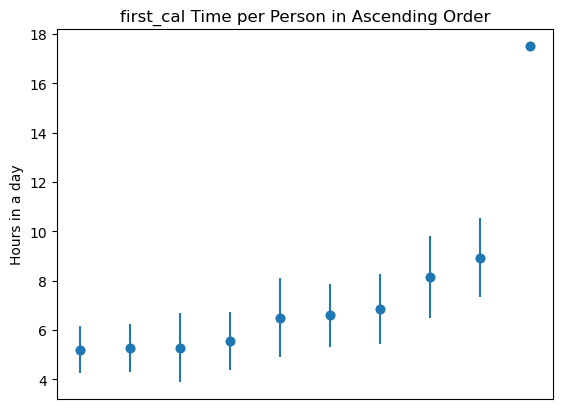

In [ ]:
first_cal_mean_with_error_bar('data/output/public_basline_usable_expanded.pickle','unique_code', 'date', 'local_time')

In [ ]:
#| export
def last_cal_mean_with_error_bar(data_source, identifier, date_col, time_col, min_log_num=2, min_separation=4):
    """
    Description:\n
       This function takes the loggings in good logging days, calculates the means and standard deviations of last_cal time for each participant and represent the calculated data with a scatter plot where the x axis is participants and the y axis is hours in a day.\n
    
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        - min_log_num (count,int): filtration criteria on the minimum number of loggings each day.
        - min_seperation(hours,int): filtration criteria on the minimum separations between the earliest and latest loggings each day.
        
    Return:\n
        - None.\n
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    df = file_loader(data_source)

    # leave only the loggings that are in a good logging day
    df['in_good_logging_day'] = in_good_logging_day(df, identifier, date_col, time_col, min_log_num, min_separation)
    df = df[df['in_good_logging_day']==True]

    last_cal_series = df.groupby([identifier, date_col])[time_col].max()
    
    
    # find means and stds for each person
    means = last_cal_series.groupby('unique_code').mean().to_frame().rename(columns={'local_time':'mean'})
    stds = last_cal_series.groupby('unique_code').std().fillna(0).to_frame().rename(columns={'local_time':'std'})
    
    if means.shape[0] > 50:
        print("More than 50 people are present which might make the graph look messy")
    
    temp = pd.concat([means,stds], axis=1)
    temp.sort_values('mean', inplace=True)
    
    # plot scatter plot with error bars
    plt.scatter(range(temp.shape[0]),temp['mean'])
    plt.errorbar(range(temp.shape[0]), temp['mean'], yerr=temp['std'], fmt="o")
    plt.xticks([])
    plt.ylabel("Hours in a day")
    plt.title('last_cal Time per Person in Ascending Order')

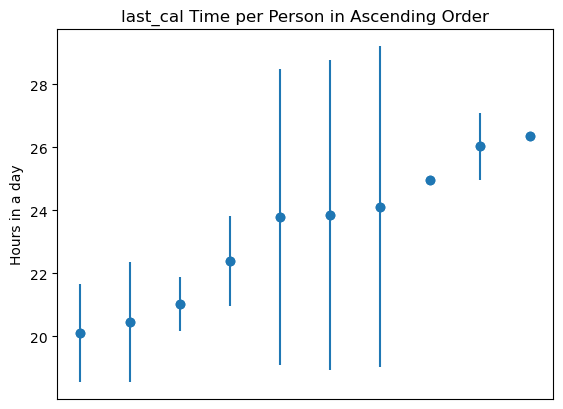

In [ ]:
last_cal_mean_with_error_bar('data/output/public_basline_usable_expanded.pickle','unique_code', 'date', 'local_time')

In [ ]:
#| export
def first_cal_analysis_variability_plot(data_source,identifier, date_col, time_col, min_log_num=2, min_separation=4):
    """
    Description:\n
       This function calculates the variability of loggings in good logging day by subtracting 5%,10%,25%,50%,75%,90%,95% quantile of first_cal time from the 50% first_cal time. It can also make a histogram that represents the 90%-10% interval for all subjects.\n
    
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        - min_log_num (count,int): filtration criteria on the minimum number of loggings each day.
        - min_seperation(hours,int): filtration criteria on the minimum separations between the earliest and latest loggings each day.
        - plot(bool) : Whether generating a histogram for first_cal variability. Default = True.
        
    Return:\n
        - A dataframe that contains 5%,10%,25%,50%,75%,90%,95% quantile of first_cal time minus 50% time for each subjects from the data_source file.\n
        
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    

    df = file_loader(data_source)
        
    # leave only the loggings in a good logging day
    df['in_good_logging_day'] = in_good_logging_day(df, identifier, date_col, time_col, min_log_num, min_separation)
    df = df[df['in_good_logging_day']==True]
    
    first_cal_series = df.groupby(['unique_code', 'date'])['local_time'].min().groupby('unique_code').quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95])
    first_cal_df = pd.DataFrame(first_cal_series)
    all_rows = []
    for index in first_cal_df.index:
        tmp_dict = dict(first_cal_series[index[0]])
        tmp_dict['id'] = index[0]
        all_rows.append(tmp_dict)
    first_cal_summary_df = pd.DataFrame(all_rows, columns = ['id', 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])\
        .rename(columns = {0.05: '5%', 0.1: '10%', 0.25: '25%', 0.5: '50%', 0.75: '75%', 0.9: '90%', 0.95: '95%'})\
        .drop_duplicates().reset_index(drop = True)
    first_cal_variability_df = first_cal_summary_df.copy()
    
    for col in first_cal_variability_df.columns:
        if col == 'id' or col == '50%':
            continue
        first_cal_variability_df[col] = first_cal_variability_df[col] - first_cal_variability_df['50%']
    first_cal_variability_df['50%'] = first_cal_variability_df['50%'] - first_cal_variability_df['50%']
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    sns_plot = sns.distplot( first_cal_variability_df['90%'] - first_cal_variability_df['10%'] )
    ax.set(xlabel='Variation Distribution for first_cal (90% - 10%)', ylabel='Kernel Density Estimation')
    

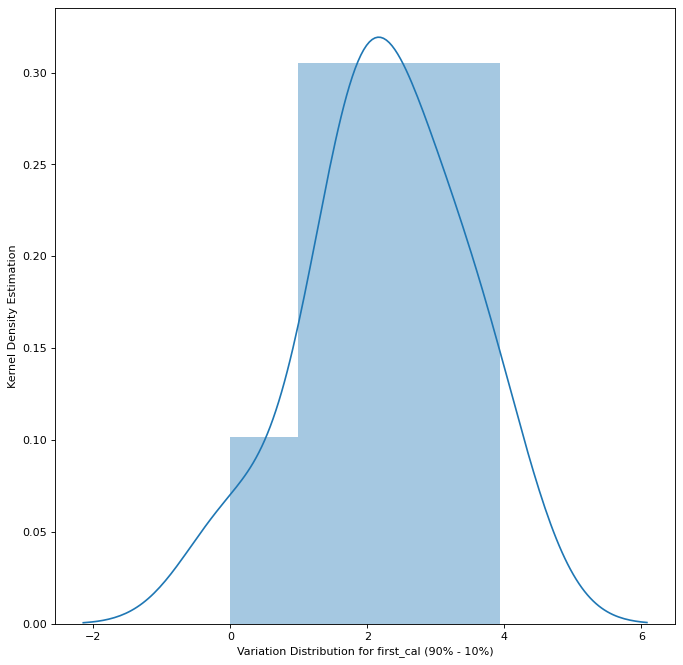

In [ ]:
first_cal_analysis_variability_plot('data/output/public_basline_usable_expanded.pickle','unique_code', 'date', 'local_time') 

In [ ]:
#| export
def last_cal_analysis_variability_plot(data_source, identifier, date_col, time_col, min_log_num=2, min_separation=4):
    """
    Description:\n
       This function calculates the variability of loggings in good logging day by subtracting 5%,10%,25%,50%,75%,90%,95% quantile of last_cal time from the 50% last_cal time and makes a histogram that represents the 90%-10% interval for all subjects.\n
    
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        - min_log_num (count,int): filtration criteria on the minimum number of loggings each day.
        - min_seperation(hours,int): filtration criteria on the minimum separations between the earliest and latest loggings each day.
        - plot(bool) : Whether generating a histogram for first_cal variability. Default = True.
    Return:\n
        - None\n
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    
    df = file_loader(data_source)
        
    # leave only the loggings that are in a good logging day
    df['in_good_logging_day'] = in_good_logging_day(df, identifier,date_col, time_col, min_log_num, min_separation)
    df = df[df['in_good_logging_day']==True]
    
    last_cal_series = df.groupby(['unique_code', 'date'])['local_time'].max().groupby('unique_code').quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95])
    last_cal_df = pd.DataFrame(last_cal_series)
    all_rows = []
    for index in last_cal_df.index:
        tmp_dict = dict(last_cal_series[index[0]])
        tmp_dict['id'] = index[0]
        all_rows.append(tmp_dict)
    last_cal_summary_df = pd.DataFrame(all_rows, columns = ['id', 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])\
        .rename(columns = {0.05: '5%', 0.1: '10%', 0.25: '25%', 0.5: '50%', 0.75: '75%', 0.9: '90%', 0.95: '95%'})\
        .drop_duplicates().reset_index(drop = True)
    last_cal_variability_df = last_cal_summary_df.copy()
    
    for col in last_cal_variability_df.columns:
        if col == 'id' or col == '50%':
            continue
        last_cal_variability_df[col] = last_cal_variability_df[col] - last_cal_variability_df['50%']
    last_cal_variability_df['50%'] = last_cal_variability_df['50%'] - last_cal_variability_df['50%']
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    sns_plot = sns.distplot( last_cal_variability_df['90%'] - last_cal_variability_df['10%'] )
    ax.set(xlabel='Variation Distribution for last_cal (90% - 10%)', ylabel='Kernel Density Estimation')
    

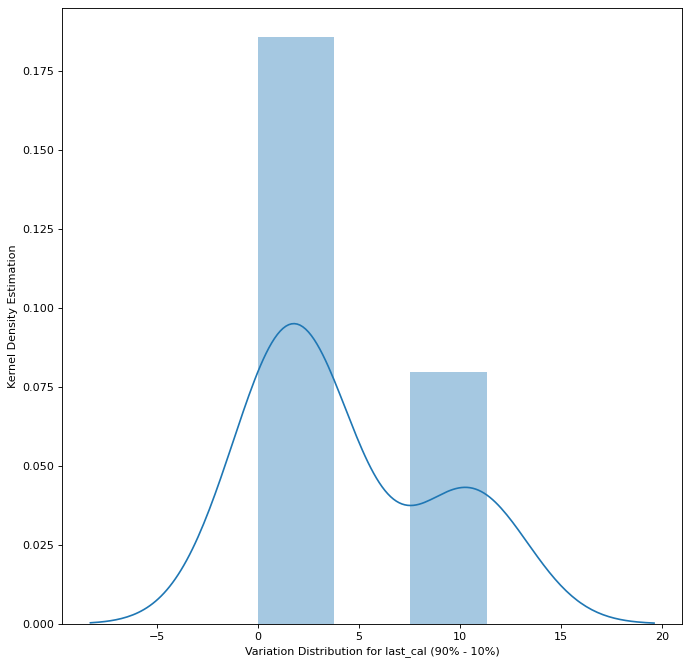

In [ ]:
last_cal_analysis_variability_plot('data/output/public_basline_usable_expanded.pickle','unique_code', 'date', 'local_time')

In [ ]:
#| export
def first_cal_avg_histplot(data_source, identifier, date_col, time_col):
    """
    Description:\n
       This function take the first caloric event (no water or med) and calculate average event's time for “each participant”.\n
    
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.

    Return:\n
        - None
        
    Requirements:\n
        data_source file must have the following columns:\n
            - food_type\n
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    df = file_loader(data_source)
    df = df.query('food_type in ["f", "b"]')
    first_cal_time = df.groupby([identifier, date_col])[time_col].min()
    avg_first_cal_time = first_cal_time.reset_index().groupby(identifier)[time_col].mean()
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    sns.distplot(avg_first_cal_time, kde = False)
    ax.set(xlabel='First Meal Time - Averaged by Person', ylabel='Frequency Count')

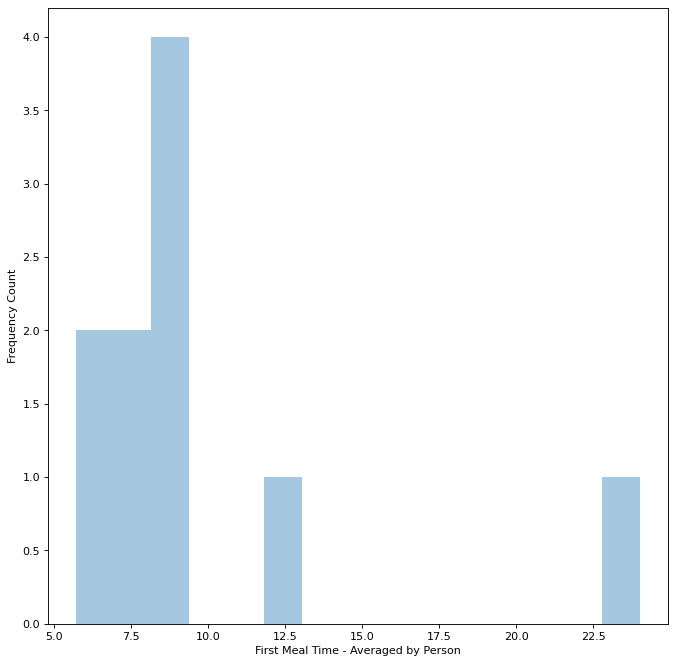

In [ ]:
first_cal_avg_histplot('data/output/public_basline_usable_expanded.pickle','unique_code', 'date', 'local_time')

In [ ]:
#| export
def first_cal_sample_distplot(data_source, n, identifier, date_col, time_col):
    """
    Description:\n
       This function plots the distplot for the first_cal time from n participants that will be randomly selected with replacement.\n
    
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.\n
        - n (int): the number of distplot in the output figure
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        
    Return:\n
        - None
        
    Requirements:\n
        data_source file must have the following columns:\n
            - food_type\n
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    df = file_loader(data_source)
    df = df[df['food_type'].isin(['f','b'])]
    first_cal_by_person = pd.DataFrame(df.groupby([identifier, date_col])\
                                       [time_col].min())
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    
    print('Plotting distplots for the following users:')
    for i in np.random.choice(np.array(list(set(first_cal_by_person.index.droplevel(date_col)))), n):
        print(i)
        sns.distplot(first_cal_by_person[time_col].loc[i])

Plotting distplots for the following users:
alqt16675467779
alqt21525720972
alqt21525720972
alqt45631586569
alqt45631586569


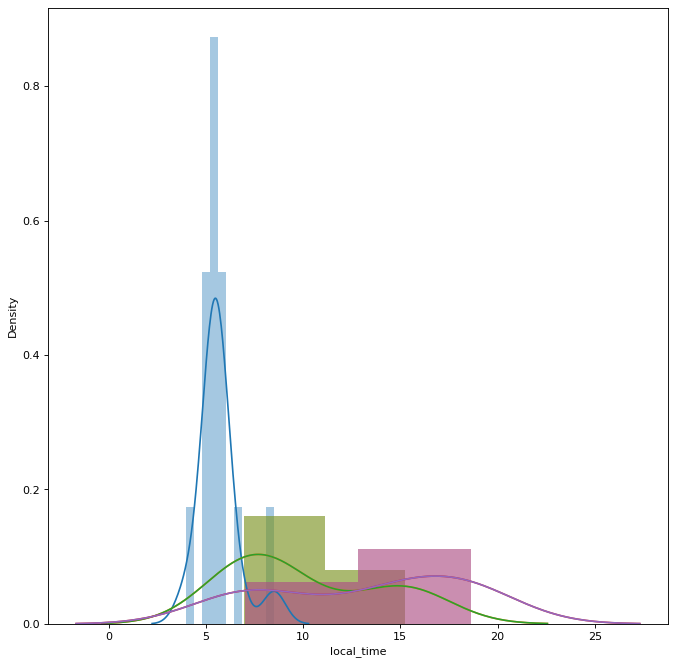

In [ ]:
first_cal_sample_distplot('data/output/public_intervention_usable.pickle',5, 'unique_code', 'date', 'local_time')

In [ ]:
#| export
def last_cal_avg_histplot(data_source, identifier, date_col, time_col):
    """
    Description:\n
       This function take the last caloric event (no water or med) and calculate average event's time for “each participant”.\n
    
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.

    Return:\n
        - None
        
    Requirements:\n
            - food_type\n
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    df = file_loader(data_source)
    df = df.query('food_type in ["f", "b"]')
    last_cal_time = df.groupby([identifier, date_col])[time_col].max()
    avg_last_cal_time = last_cal_time.reset_index().groupby(identifier)[time_col].mean()
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    sns.distplot(avg_last_cal_time, kde = False)
    ax.set(xlabel='Last Meal Time - Averaged by Person', ylabel='Frequency Count')

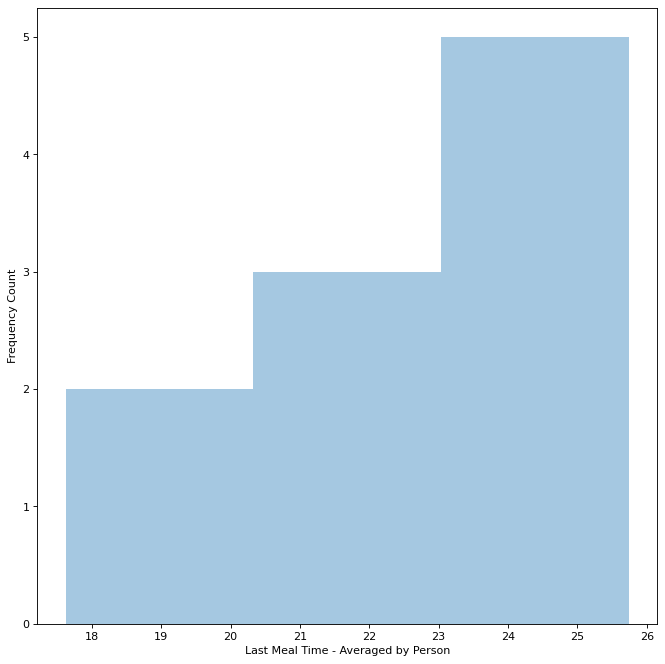

In [ ]:
last_cal_avg_histplot('data/output/public_basline_usable_expanded.pickle','unique_code', 'date', 'local_time')

In [ ]:
#| export
def last_cal_sample_distplot(data_source, n, identifier, date_col, time_col):
    """
    Description:\n
       This function plots the distplot for the last_cal time from n participants that will be randomly selected with replacement.\n
    
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - n (int): the number of participants that will be randomly selected in the output figure
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        
    Return:\n
        - None
        
    Requirements:\n
        - food_type
    
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
        
    """
    df = file_loader(data_source)
    df = df[df['food_type'].isin(['f','b'])]
    last_cal_by_person = pd.DataFrame(df.groupby([identifier, date_col])\
                                       [time_col].max())
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    
    print('Plotting distplots for the following users:')
    for i in np.random.choice(np.array(list(set(last_cal_by_person.index.droplevel(date_col)))), n):
        print(i)
        sns.distplot(last_cal_by_person[time_col].loc[i])

Plotting distplots for the following users:
alqt16675467779
alqt8668165687
alqt21525720972
alqt45631586569
alqt14018795225


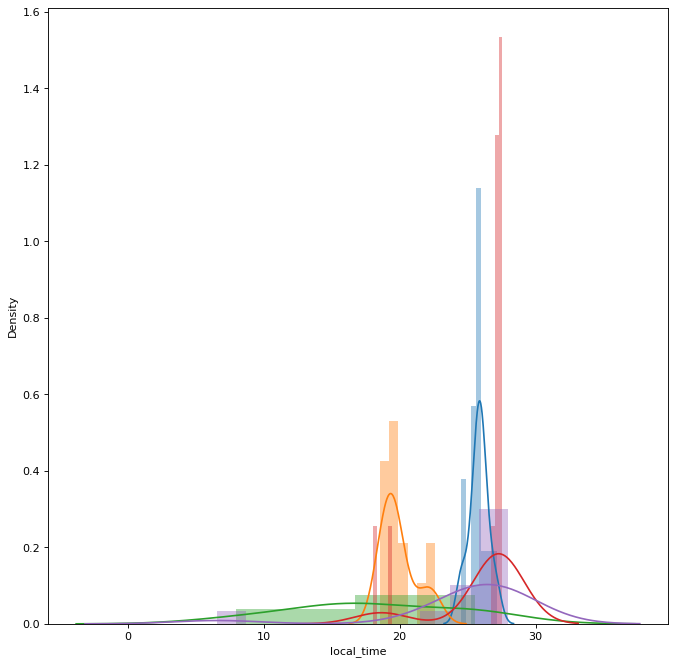

In [ ]:
last_cal_sample_distplot('data/output/public_intervention_usable.pickle',5,'unique_code', 'date', 'local_time')

In [ ]:
#| export
def swarmplot(data_source, max_loggings, identifier, date_col, time_col):
    """
    Description:\n
       This function plots the swarmplot the participants from the data_source file.\n
    
    Input:\n
        - data_source (str, pandas df): input path, file in pickle, csv or panda dataframe format.\n
        - max_loggings (int): the max number of loggings to be plotted for each participants, loggings will be randomly selected.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
    Return:\n
        - None
        
    Requirements:\n
        data_source file must have the following columns:\n
            - food_type\n
    Optional functions to use to have proper inputs:
        - find_date() for date_col
        - find_float_time() for time_col
    """
    
    df = file_loader(data_source)
    
    def subsamp_by_cond(alldat):
        alld = []
        for apart in alldat[identifier].unique():
            dat = alldat[alldat[identifier]==apart]
            f_n_b = dat.query('food_type in ["f", "b"]')
            n = min([f_n_b.shape[0], max_loggings])
            sub = f_n_b.sample(n = n, axis=0)
            alld.append(sub)
        return pd.concat(alld)

    sample = subsamp_by_cond(df)
    fig, ax = plt.subplots(1, 1, figsize = (10, 30), dpi=300)


    ax.axvspan(3.5,6, alpha=0.2, color=[0.8, 0.8, 0.8]  )
    ax.axvspan(18,28.5, alpha=0.2, color=[0.8, 0.8, 0.8]  )
    # plt.xlabel('Hour of day')
    plt.xticks([4,8,12,16,20,24,28],[4,8,12,16,20,24,4])
    plt.title('Food events for TRE group')

    ax = sns.swarmplot(data = sample, 
                  y = identifier, 
                  x = time_col, 
                  dodge = True, 
                  color = sns.xkcd_rgb['golden rod'],
                 )

    ax.set(
        facecolor = 'white', 
        title = 'Food events (F & B)',
        ylabel = 'Participant',
        xlabel = 'Local time of consumption'
    )

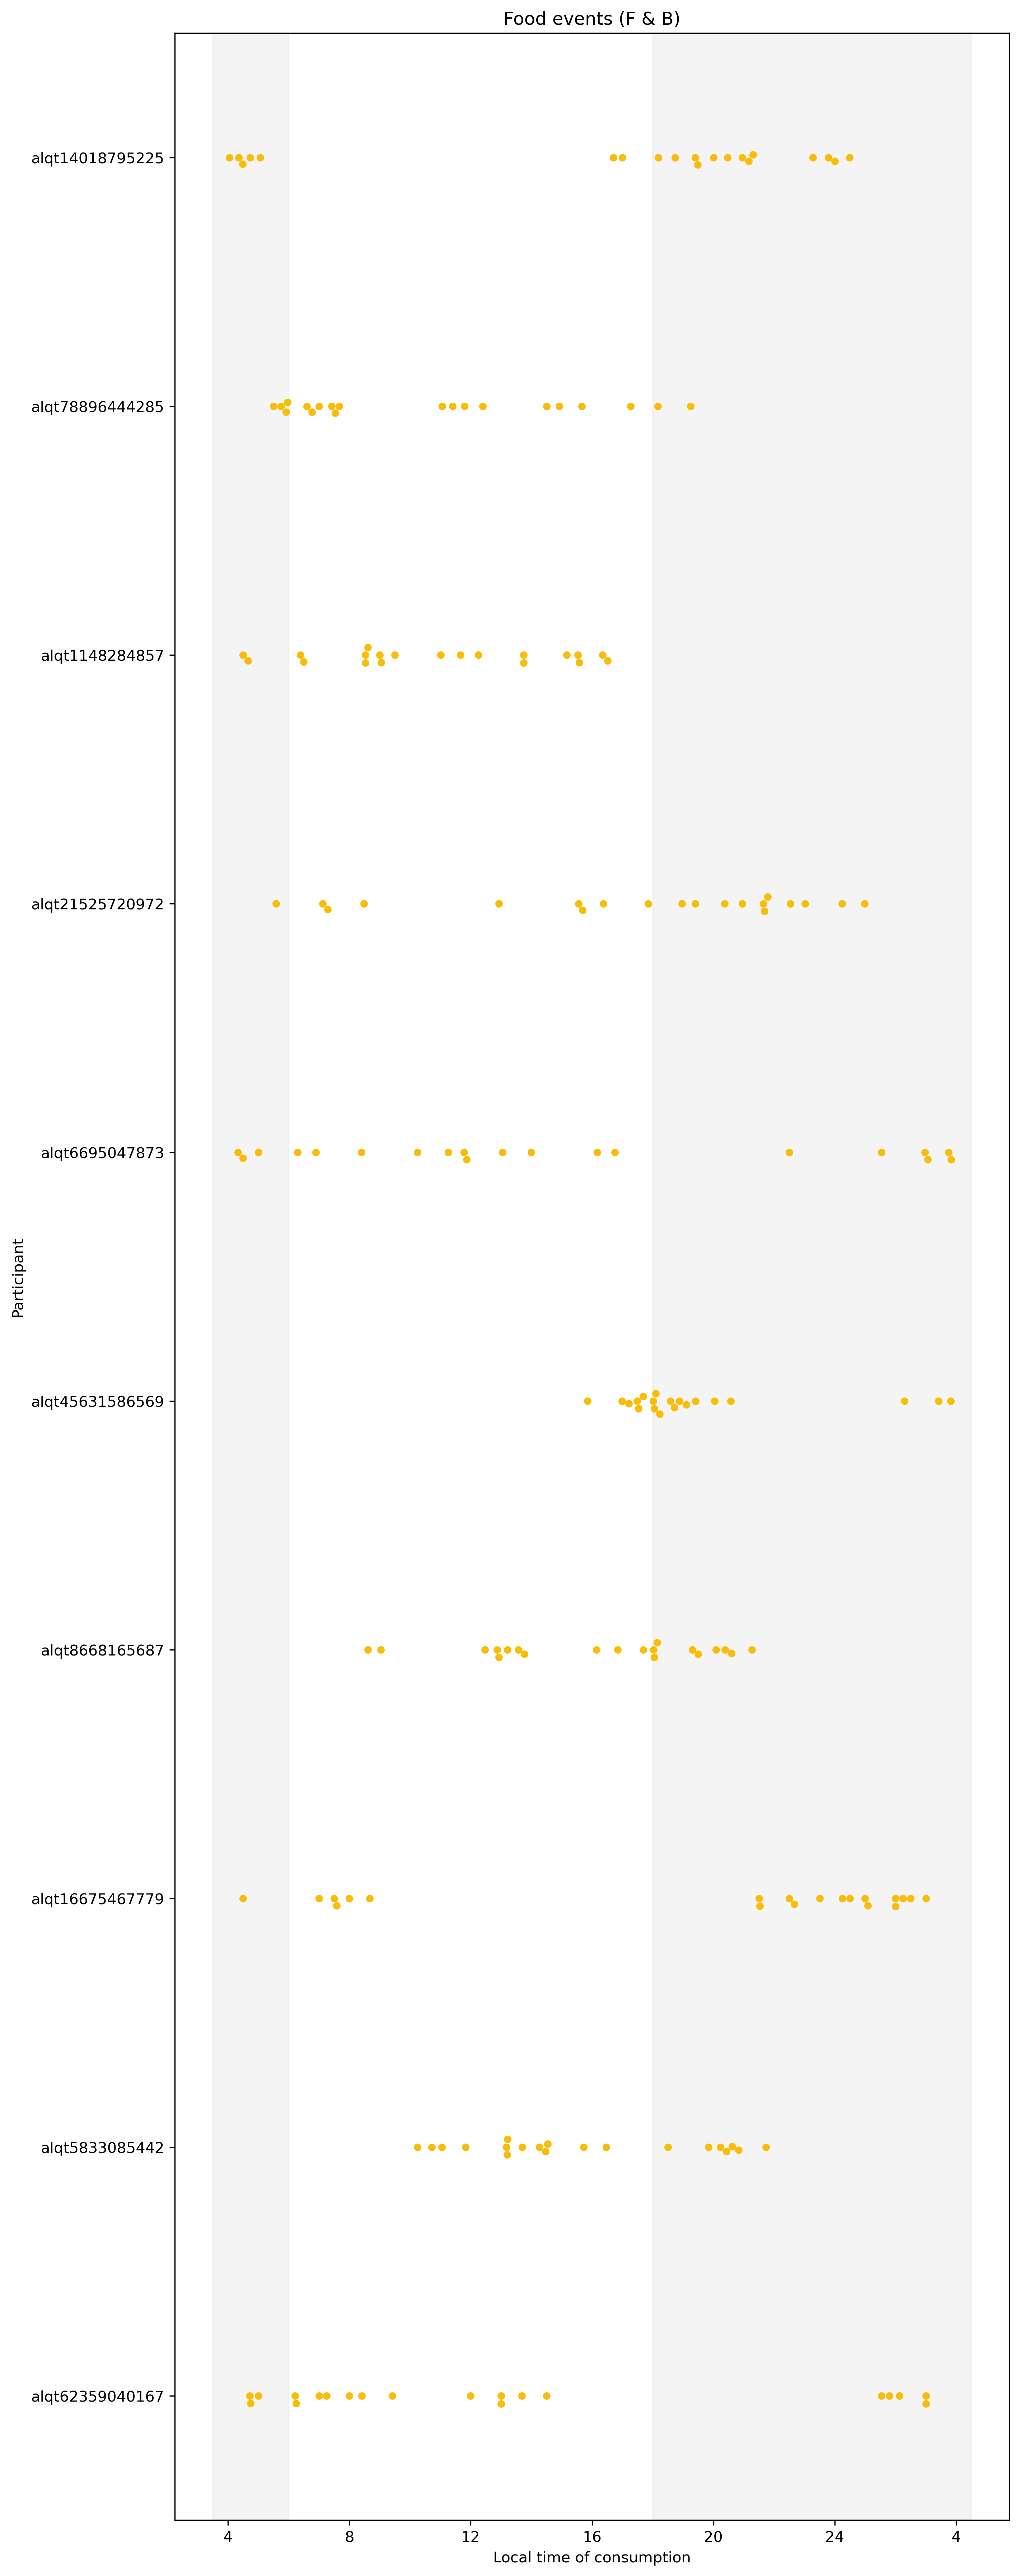

In [ ]:
swarmplot('data/output/public.pickle', 20,'unique_code', 'date', 'local_time')